# IUI Assignment Sheet

If necessary, install the required packages in `requirements.txt` via `pip`.

## Loading the Dataset into RAM

Make sure that the two cells below load without error message.

In [1]:
!pip install opencv-python
!pip install torchvision

/bin/bash: /usr/local/bin/pip: /usr/bin/python3.8: bad interpreter: No such file or directory
/bin/bash: /usr/local/bin/pip: /usr/bin/python3.8: bad interpreter: No such file or directory


In [19]:
import os
import json
import cv2
from matplotlib import pyplot as plt
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from skimage.util import random_noise
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import pandas as pd



class_to_annotation =  {
            "pitch": {0: "HE", 1: "SI", 2: "YI", 3: "SHANG", 4: "GOU", 5: "CHE", 6: "GONG", 7: "FAN", 8: "LIU", 9: "WU", 10: "GAO_WU"},
            "secondary": {0: None, 1: "DA_DUN", 2: "XIAO_ZHU", 3: "DING_ZHU", 4: "DA_ZHU", 5: "ZHE", 6: "YE"}
}
    
annotation_to_class = {"pitch": {"HE": 0,
                                 "SI": 1,
                                 "YI": 2,
                                 "SHANG": 3,
                                 "GOU": 4,
                                 "CHE": 5,
                                 "GONG": 6,
                                 "FAN": 7,
                                 "LIU": 8,
                                 "WU": 9,
                                 "GAO_WU": 1},
                       "secondary": {None: 0,
                                     "DA_DUN": 1,
                                     "XIAO_ZHU": 2,
                                     "DING_ZHU": 3,
                                     "DA_ZHU": 4,
                                     "ZHE": 5,
                                     "YE": 6}}

## this function takes the path_to_folder (i.e., the folder where the dataset.json is in)
## and returns a list of the dataset entries. Each entry consists of the keys:
##     "image_path": 
##     "type": The type of the box (in our case, this is 'Music' only)
##     "annotation": The annotation string
##     "image": The image as uint8 array representation
##     "is_simple": This is True if the notation is "simple notation" as opposed to "composite notation"
def open_dataset(path_to_folder):
    path_to_json = os.path.join(path_to_folder, "dataset.json")
    with open(path_to_json) as file:
        dataset_json = json.load(file)
        return_dataset = []
        
        for idx in range(len(dataset_json)):
            if dataset_json[idx]["annotation"]["pitch"] == None:
                continue
            curr_entry = {}
            curr_entry["annotation"] = {}
            curr_entry["image"] = cv2.imread(os.path.join(path_to_folder, dataset_json[idx]["image_path"]), cv2.IMREAD_GRAYSCALE)
            curr_entry["is_simple"] = True if (dataset_json[idx]["annotation"]["secondary"] is None) else False
            curr_entry["annotation"]["pitch"] = annotation_to_class["pitch"][dataset_json[idx]["annotation"]["pitch"]]
            curr_entry["annotation"]["secondary"] = annotation_to_class["secondary"][dataset_json[idx]["annotation"]["secondary"]]
            curr_entry["edition"] = os.path.basename(dataset_json[idx]["image_path"]).split("_")[0]
            curr_entry["image_id"] = dataset_json[idx]["image_path"].split("_")[0] + "_" + dataset_json[idx]["image_path"].split("_")[1] + "_" + dataset_json[idx]["image_path"].split("_")[2]
            return_dataset.append(curr_entry)
    return return_dataset

In [20]:
dataset = open_dataset("./DATASET/Music/")

print(dataset[0].keys())
pages_set = set([])
for piece in dataset:
    try:
        pages_set.add(piece["image_id"])
    except Exception:
        pass
    
print(len(pages_set))
print(pages_set)

dict_keys(['annotation', 'image', 'is_simple', 'edition', 'image_id'])
68
{'images/siku_edition_055', 'images/lu_edition_088', 'images/zhu_edition_055', 'images/lu_edition_104', 'images/lu_edition_057', 'images/siku_edition_092', 'images/zhang_edition_083', 'images/siku_edition_111', 'images/zhang_edition_044', 'images/siku_edition_064', 'images/lu_edition_048', 'images/lu_edition_099', 'images/lu_edition_089', 'images/zhu_edition_037', 'images/siku_edition_102', 'images/zhu_edition_085', 'images/siku_edition_094', 'images/zhu_edition_081', 'images/siku_edition_040', 'images/siku_edition_107', 'images/zhang_edition_046', 'images/zhu_edition_089', 'images/zhang_edition_034', 'images/zhang_edition_076', 'images/zhu_edition_075', 'images/siku_edition_101', 'images/lu_edition_103', 'images/siku_edition_097', 'images/siku_edition_104', 'images/zhu_edition_076', 'images/lu_edition_091', 'images/lu_edition_095', 'images/zhang_edition_079', 'images/lu_edition_093', 'images/siku_edition_112', '

## Visualization of the Dataset

Great, now that the dataset is loaded into RAM, let's familiarize ourselves with the dataset and find out some things!

In the cell below, the first four samples of the dataset are displayed, with the annotation string below.

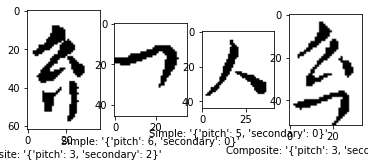

In [21]:
display_n = 4
for idx in range(display_n):
    plt.subplot(1, display_n, idx+1)
    plt.imshow(dataset[idx]["image"], cmap='gray')
    
    is_simple = "Simple" if dataset[idx]["is_simple"] else "Composite"
    annotation = dataset[idx]["annotation"]
    plt.xlabel(f"{is_simple}: '{annotation}'")

Okay, let's get to the next step and gather some information about the dataset!

In [22]:
print("Total number of instances:             ", len(dataset))
print("Total number of simple notations:      ", sum(1 for entry in dataset if entry["is_simple"]))
print("Total number of composite notations:   ", sum(1 for entry in dataset if not entry["is_simple"]))

Total number of instances:              5724
Total number of simple notations:       4141
Total number of composite notations:    1583


<br><br><br><br><br><br><br><br><br>

# <font color='black'>Task 1: Visualize the Simple and Total Subsets</font>

Fill out the visualization functions below.

Visualize the number of classes for the "Simple Notation Problem", and to find out how the classes are distributed and if there are any imbalances in the dataset. E.g., this can be achieved with a pie chart or a bar chart.

Visualize the distribution of the whole 77 classes, I recommend a heatmap for this, e.g. in this style: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html. If you decide to take this kind of heatmap, please use a monochrome color scheme, e.g. 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds' (https://matplotlib.org/stable/users/explain/colors/colormaps.html), since mixed color schemes are more difficult to interpret visually.

In [25]:
import seaborn as sns 
def visualize_simple(dataset):
    
    labels = "He", "Si", "Yi", "Shang", "Gou", "Che", "Gong", "Fan", "Liu", "Wu", "Gao Wu"
    sizes = []

    simple_list = [entry for entry in dataset if(entry['is_simple'] == True)]

    for pitch_symbol in class_to_annotation["pitch"].values():
        sizes.append(len([entry for entry in simple_list if(entry['annotation']["pitch"] == pitch_symbol)]))
    print(sizes)

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
    
        # Define a list of shades of purple
    #colors = ['#f2ebff', '#d9ccff', '#c299ff', '#ad73ff', '#9966ff', '#804fff', '#6633cc', '#4d2d80', '#331a66', '#1a0d33', '#00001a']

    #fig, ax = plt.subplots()
    # Use the defined shades of purple for the pie chart
    #ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    
    print(list(zip(labels, sizes)))

visualize_simple(dataset)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

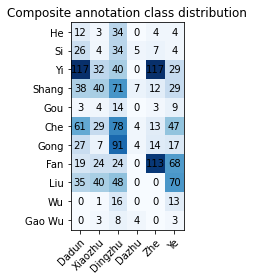

In [29]:
def visualize_composite(dataset):    
    composite_list = [entry for entry in dataset if(entry['is_simple'] == False)]

    simple_annotation = ["He", "Si", "Yi", "Shang", "Gou", "Che", "Gong", "Fan", "Liu", "Wu", "Gao Wu"]
    composite_annotation = ["Dadun", "Xiaozhu", "Dingzhu", "Dazhu", "Zhe", "Ye"]

    data = []
    indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    for index in indices:
        temp = []
        for i in range(1,7):
            temp.append(len([entry for entry in composite_list if(entry['annotation'] == [index, i])]))
        #check if temp is all zeros
        if (np.any(temp)):
            data.append(temp)


    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='Blues')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(composite_annotation)), labels=composite_annotation)
    ax.set_yticks(np.arange(len(simple_annotation)), labels=simple_annotation)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(simple_annotation)):
        for j in range(len(composite_annotation)):
            text = ax.text(j, i, data[i][j], ha="center", va="center", color="black")

    ax.set_title("Composite annotation class distribution")
    fig.tight_layout()
    plt.show()
    
    
visualize_composite(dataset)

    #######################################
    #########         TODO         ########
    #######################################
    
    Answer the following questions:
    
        What are your conclusions out of the visualization?
        Looking at the both visual representations, for the simple notations as well as the whole dataset, we can see that certain types of notations are present in bigger quantities than others. Specifically we can look at the big gap between Che and Gao Wu symbols - one takes up 16% of the data while the other one only 1.8%. This yields a pretty straight forward conclusion - the model will have more opportunities to learn to correctly recognize the Che symbols than the other ones. This disbalance in the simple notation also impacts the composite notations as we can see that the number of compisite notations made by combining these symbols also is representative of the gap in data precentage.
    
    How balanced is the dataset?
        The dataset is not very well balanced as the symbols are not equally represented - there is a disbalance in the percentage of each symbol of the set. The disbalance of simple symbols also impacts the numbers of composite symbols as they are combination of simple notations and six diffferent additional notations.
    
    Which problems in training a model may be caused by the (im)balancedness of the dataset? Which problems in training a model may be caused by ratio simple notations : composite notations?
        Well, as mentioned before, the disbalance in the datasets can impact the quality of model predictions as it will be trained better to recognize certain symbols and not trained well enough for others (give less accurate results). Composite notations are a separate cateogry when hardness of classification comes in play and the issue is that we do not even have data for certain combinations of symbols. This means that in the future, if the model is given a symbol it did not see before not even once, it might have issues classifying it as it has no prior knowledge.

## Image Properties

In [30]:
def print_image_properties(dataset):
    print("Minimal image width:", min([entry["image"].shape[0] for entry in dataset]))
    print("Mean    image width:", sum([entry["image"].shape[0] for entry in dataset])/len(dataset))
    print("Maximal image width:", max([entry["image"].shape[0] for entry in dataset]))
    print()
    print("Minimal image height:", min([entry["image"].shape[1] for entry in dataset]))
    print("Mean    image height:", sum([entry["image"].shape[1] for entry in dataset])/len(dataset))
    print("Maximal image height:", max([entry["image"].shape[1] for entry in dataset]))
    
print_image_properties(dataset)

Minimal image width: 20
Mean    image width: 42.70125786163522
Maximal image width: 81

Minimal image height: 18
Mean    image height: 34.99737945492662
Maximal image height: 60


### We can see that for the individual images, both the width and the height vary greatly. Let's take a closer look!

In the two cells below, we investigate the four samples with the smallest and the four samples with the largest width, respectively for the height. We can see that this is not an error in the data itself, but rather a feature of the individual editions, and as well as the whitespace around each character.

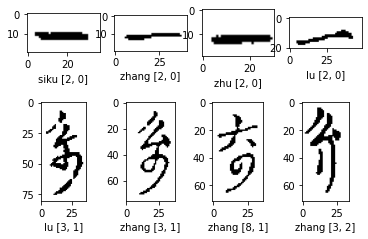

In [31]:
def show_sorted_by_width(dataset):
    sorted_by_width = sorted([entry for entry in dataset], key=lambda entry: entry["image"].shape[0])
    display_n = 4
    for idx in range(display_n):
        plt.subplot(2, display_n, idx+1)
        plt.imshow(sorted_by_width[idx]["image"], cmap='gray')
        path = os.path.basename(sorted_by_width[idx]["image_path"]).split("_")[0]
        annotation = str(sorted_by_width[idx]["annotation"])
        plt.xlabel(f"{path} {annotation}")
        
    for idx in range(display_n):
        plt.subplot(2, display_n, display_n+idx+1)
        plt.imshow(sorted_by_width[-idx-1]["image"], cmap='gray')
        path = os.path.basename(sorted_by_width[-idx-1]["image_path"]).split("_")[0]
        annotation = str(sorted_by_width[-idx-1]["annotation"])
        plt.xlabel(f"{path} {annotation}")
        
show_sorted_by_width(dataset)

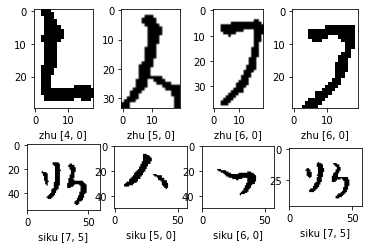

In [32]:
def show_sorted_by_height(dataset):
    sorted_by_height = sorted([entry for entry in dataset], key=lambda entry: entry["image"].shape[1])
    display_n = 4
    for idx in range(display_n):
        plt.subplot(2, display_n, idx+1)
        plt.imshow(sorted_by_height[idx]["image"], cmap='gray')
        path = os.path.basename(sorted_by_height[idx]["image_path"]).split("_")[0]
        annotation = str(sorted_by_height[idx]["annotation"])
        plt.xlabel(f"{path} {annotation}")

    for idx in range(display_n):
        plt.subplot(2, display_n, display_n+idx+1)
        plt.imshow(sorted_by_height[-idx-1]["image"], cmap='gray')
        path = os.path.basename(sorted_by_height[-idx-1]["image_path"]).split("_")[0]
        annotation = str(sorted_by_height[-idx-1]["annotation"])
        plt.xlabel(f"{path} {annotation}")

show_sorted_by_height(dataset)

<br><br><br><br><br><br><br><br>

# Task 2: Write a function to crop away the excess whitespace


In [33]:
def remove_small_blobs(image):  # remove small isolated connected black areas
    noise_removal_threshold = 1  
    mask = np.ones_like(image)*255
    contours, hierarchy = cv2.findContours(255-image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
      area = cv2.contourArea(contour)
      if area >= noise_removal_threshold:
        cv2.fillPoly(mask, [contour], 0)
    return mask


def crop_excess_whitespace(image):
    gray = 255*(image < 128).astype(np.uint8) #reverse the colors
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    rect = image[y:y+h, x:x+w]
    return rect

In [1]:
def get_cropped_dataset(dataset):  ## creates a new dataset where each of the images is cropped
    cropped_dataset = copy.deepcopy(dataset)
    for idx in range(len(cropped_dataset)):
        cropped_dataset[idx]["image"] = crop_excess_whitespace(remove_small_blobs(dataset[idx]["image"]))
        #cropped_dataset[idx]["image"] = remove_small_blobs(dataset[idx]["image"])
    return cropped_dataset
        
cropped_dataset = get_cropped_dataset(dataset)
show_sorted_by_width(cropped_dataset)

import pickle
with open("edition_data.pkl", "ab") as file_handle:
    pickle.dump(cropped_dataset, file_handle)
    
print(cropped_dataset)

NameError: name 'dataset' is not defined

Minimal image width: 4
Mean    image width: 31.122117400419288
Maximal image width: 69

Minimal image height: 13
Mean    image height: 26.64430468204053
Maximal image height: 45


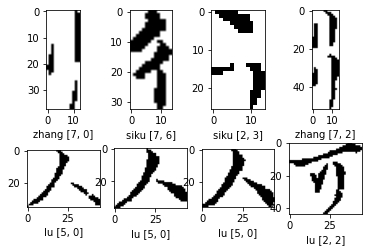

In [35]:
show_sorted_by_height(cropped_dataset)
print_image_properties(cropped_dataset)

<br><br><br><br><br><br><br><br>

# Task 3: Data Augmentation

Have a look at the object `total_transforms` defined below. In it, all the transformations and data augmentations applied to the image are stored.

1. Complete the functions `shrink` and `paste_to_square`, for data augmentation. Tip: Take a look at the torchvision transforms: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html.
2. Can you think of other meaningful data augmentations? Try to have a look at the data!

In [36]:

target_size = 28

import math

def shrink(is_random=True):
    
    def inner(input_image):
         
        t_size = random.randint(15, 22)  # random.randint(target_size // 2, target_size - 5) if is_random else target_size - 5
        
        original_width = input_image.shape[-1]
        original_height = input_image.shape[-2]
        aspect_ratio = original_width / original_height * random.uniform(0.6, 1.5) if is_random else original_width / original_height
        
        if aspect_ratio > 1:
            w = int(t_size)
            h = int(t_size / aspect_ratio)
        else: 
            w = int(t_size * aspect_ratio)
            h = int(t_size)

        output_image = transforms.Resize(size=(h, w), interpolation=transforms.InterpolationMode.NEAREST_EXACT)(input_image)
        return output_image
    
    return inner

In [37]:
def paste_to_square(is_random=True):
    
    def inner(input_image):
        ## Modify the function to extend the
        ## input image to a square of 40x40.
        ## Tip: This can be done by clever use
        ## of the Pad function
        ## https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html
        ## Also make sure that the added padding
        ## on each side is random, i.e., the 
        ## data itself is augmented by its
        ## position in the square.
                
        pad_width = target_size - input_image.shape[-1]
        pad_height = target_size - input_image.shape[-2]
        
        left_pad = random.randint(0, pad_width) if is_random else pad_width//2
        top_pad = random.randint(0, pad_height) if is_random else pad_height//2
        
        right_pad = pad_width - left_pad
        bottom_pad = pad_height - top_pad
            
        output_image = transforms.Pad(padding=(left_pad, top_pad, right_pad, bottom_pad), fill=1)(input_image) 
        return output_image
    
    return inner


In [38]:
def salt_and_pepper(percentage=0.1):
    def inner(input_image):
        output_image = input_image.numpy().squeeze()
        if random.uniform(0, 1) < percentage/2:
            amount = 0.02
            output_image = random_noise(output_image, mode='salt', amount=amount)
        if random.uniform(0, 1) < percentage/2:
            amount = 0.01
            output_image = random_noise(output_image, mode='pepper', amount=amount)
        return torch.Tensor(output_image).unsqueeze(0)
    return inner

In [39]:
def erode(percentage=0.1):
    def inner(input_image):
        if random.uniform(0, 1) < percentage:  # only apply transformation according to percentage
            kernel = np.ones((2,2),np.uint8)
            output_image = cv2.erode(input_image, kernel, iterations=1)
            return output_image
        else:
            return input_image
    return inner

In [40]:
def dilate(percentage=0.1):
    def inner(input_image):
        if random.uniform(0, 1) < percentage:  # only apply transformation according to percentage
            kernel = np.ones((2,2),np.uint8)
            output_image = cv2.dilate(input_image, kernel, iterations=1)
            return output_image
        else:
            return input_image
    return inner

In [41]:
## Normalizes the dataset to have mean 0 and standard deviation of 1
## --> good for later model performance
mean_list = torch.Tensor([torch.Tensor(entry["image"]).mean() for entry in dataset])/255
mean = mean_list.mean()
std = mean_list.std()

print(mean, std)
def normalize():
    return transforms.Normalize(mean=mean, std=std)

tensor(0.8497) tensor(0.0518)


## In this cell, you can sample random combinations of the `total_transforms` as often as you like!

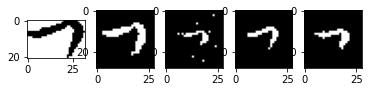

In [42]:
display_n = 5
start_idx = 1 # 308

train_transforms = transforms.Compose([
    erode(percentage=0.1), # causes the notation to be thicker
    dilate(percentage=0.1), # causes the notation to be thinner
    transforms.ToTensor(), # convert from uint8 to [0, 1]
    shrink(),
    paste_to_square(is_random=False),
    salt_and_pepper(percentage=0.8), # introduces salt-and-pepper-noise
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    transforms.RandomRotation(degrees=(-8, 8)), # randomly rotate between -12 and 12 degrees
    #lambda img: transforms.functional.invert(img), # inverts image to original color scheme
    normalize(), # normalize mean and variance
])

validation_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    #transforms.RandomRotation(degrees=(-4, 4)),
    normalize(), # normalize mean and variance
])

for idx in range(display_n):
    img = cropped_dataset[start_idx]["image"]
    if idx == 0:
        img = transforms.ToTensor()(img).squeeze()
    else:
        img = train_transforms(img).squeeze()
    
    plt.subplot(1, display_n, idx+1)
    plt.imshow(img, cmap='gray')

<br><br><br><br><br><br><br><br>

# Task 4: Defining and Training the Model

Refer to Assignment A0 - Intro to PyTorch.

Define, train and optimize the model using Optuna.

TODOs:

* First, try out to train on the simple dataset only. There, the objective function should only consider the first one-hot encoded vector (pitch vector). Try CrossEntropyLoss and BCELoss.
* Then, also try out to train on the total dataset. For the objective function, multiple options are possible. E.g., try:
    1. the sum of BCELoss over each individual element, where the output vector is the concatenation of the first and second one-hot vector
    2. (CrossEntropyLoss over first one-hot vector) + (CrossEntropyLoss over second one-hot vector)
    3. What other meaningful possibilites are there? Look for multi-label classification losses.
* Analogous to A0 assignment, report precision, recall and F1 metric for the best models.
* How does the best model for the simple notation and the best model for the total problem relate to each other? How do these models perform on the simple dataset? Why? 

In [69]:
import torch.nn as nn

class SIMPLE_CNN(nn.Module):
    def __init__(self):
        super(SIMPLE_CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        
        # fully connected layer, output 11 classes
        self.out = nn.Linear(32 * 7 * 7, 11)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

print("\n", SIMPLE_CNN())


class FashionCNN(nn.Module):
    def __init__(self, num_output_classes=11):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_output_classes)
        self.logits = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        print("HAAAPE", x.shape)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.logits(out)
        
        return out


print("\n", FashionCNN())


 SIMPLE_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=11, bias=True)
)

 FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_

In [44]:
simple_dataset = [copy.deepcopy(entry) for entry in cropped_dataset if entry["is_simple"]]
total_dataset = cropped_dataset

In [45]:
from dataclasses import dataclass

@dataclass
class Editions:
    NONE: str = None
    LU: str = "lu"
    ZHANG: str = "zhang"
    SIKU: str = "siku"
    ZHU: str = "zhu"

@dataclass
class LabelType:
    FULL: str = "full"
    FULL_PITCH_BALANCED: str = "full_pitch_balanced"
    FULL_SECONDARY_BALANCED: str = "full_secondary_balanced"
    PITCH: str = "pitch"
    PITCH_BALANCED: str = "pitch_balanced"
    SECONDARY: str = "secondary"
    SECONDARY_BALANCED: str = "secondary_balanced"

def get_dataloaders(is_simple=False, validation_edition=Editions.NONE, label_type=LabelType.PITCH_BALANCED):
    def get_datasets():
        if is_simple:
            dataset = simple_dataset
        else:
            dataset = total_dataset

        class Dataset(torch.utils.data.Dataset):
            def __init__(self, dataset: list, transform=None):
                self.X = [entry["image"] for entry in dataset]
                
                if label_type == LabelType.PITCH or label_type == LabelType.PITCH_BALANCED:
                    self.y = [entry["annotation"][0] for entry in dataset]
                elif label_type == LabelType.SECONDARY or label_type == LabelType.SECONDARY_BALANCED:
                    self.y = [entry["annotation"][1] for entry in dataset]
                else:
                    self.y = [entry["annotation"] for entry in dataset]
                    
                self.is_simple = [entry["is_simple"] for entry in dataset]
                
                
                self.transform = transform
               
            def __len__(self):
                return len(self.X)

            def __getitem__(self, idx):
                sample = self.X[idx]
                if self.transform:
                    sample = self.transform(sample)
                label = self.y[idx]
                is_simple = self.is_simple[idx]
                return sample, label, is_simple
        
        if validation_edition:
            train_data = Dataset([entry for entry in dataset if entry["edition"]!=validation_edition], transform=train_transforms)
            test_data = Dataset([entry for entry in dataset if entry["edition"]==validation_edition], transform=validation_transforms)
        else:
            # random shuffling the data
            indices = [i for i in range(len(dataset))]
            np.random.shuffle(indices)
            split = int(len(dataset) * 0.8) # 80% of data
            train_data = Dataset(dataset[:split], transform=train_transforms)
            test_data = Dataset(dataset[split:], transform=validation_transforms)
        return train_data, test_data
    
    def get_dataloaders(train_data, test_data):
        def get_sampler(y):
            inverse_class_weights = 1/np.unique(y, return_counts=True)[1]
            
            if label_type == LabelType.FULL_PITCH_BALANCED:
                inverse_weigths = [inverse_class_weights[int(label[0])] for label in y]
            elif label_type == LabelType.FULL_SECONDARY_BALANCED:
                inverse_weigths = [inverse_class_weights[int(label[1])] for label in y] 
            else:
                inverse_weigths = [inverse_class_weights[int(label)] for label in y]
                
            return torch.utils.data.WeightedRandomSampler(weights=inverse_weigths, num_samples=60000, replacement=True)

        def get_val_sampler(y):
            inverse_class_weights = 1/np.unique(y, return_counts=True)[1]
            
            if label_type == LabelType.FULL_PITCH_BALANCED:
                inverse_weigths = [inverse_class_weights[int(label[0])] for label in y]
            elif label_type == LabelType.FULL_SECONDARY_BALANCED:
                inverse_weigths = [inverse_class_weights[int(label[1])] for label in y] 
            else:
                inverse_weigths = [inverse_class_weights[int(label)] for label in y]
                
            return torch.utils.data.WeightedRandomSampler(weights=inverse_weigths, num_samples=len(y), replacement=True)
        
        sample = label_type == LabelType.PITCH_BALANCED or label_type == LabelType.SECONDARY_BALANCED or label_type == LabelType.FULL_PITCH_BALANCED or label_type == LabelType.FULL_SECONDARY_BALANCED
                    
        train_sampler = get_sampler(train_data.y) if sample else None
        test_sampler = get_val_sampler(test_data.y) if sample else None

        loaders = {
            'train' : torch.utils.data.DataLoader(train_data, 
                                                  batch_size=100, 
                                                  sampler=train_sampler),

            'test'  : torch.utils.data.DataLoader(test_data, 
                                                  batch_size=100, 
                                                  sampler=test_sampler),
        }
        
        return loaders
    
    train_data, test_data = get_datasets()
    

    return get_dataloaders(train_data, test_data)

## In the next few cells, you can tweak training and testing parameters

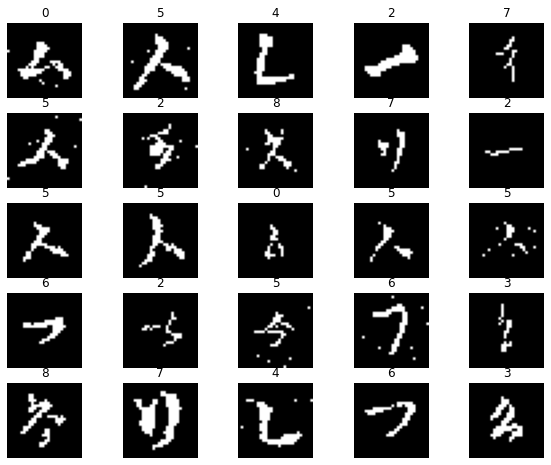

In [46]:
def visualize_dataloader(dl):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dl), size=(1,)).item()
        img, label, _ = dl.dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

loaders_pitch_none = get_dataloaders(is_simple=False, validation_edition=Editions.NONE, label_type=LabelType.PITCH_BALANCED)
loaders_pitch_zhang = get_dataloaders(is_simple=False, validation_edition=Editions.ZHANG, label_type=LabelType.PITCH_BALANCED)
loaders_pitch_zhu = get_dataloaders(is_simple=False, validation_edition=Editions.ZHU, label_type=LabelType.PITCH_BALANCED)
loaders_pitch_siku = get_dataloaders(is_simple=False, validation_edition=Editions.SIKU, label_type=LabelType.PITCH_BALANCED)
loaders_pitch_lu = get_dataloaders(is_simple=False, validation_edition=Editions.LU, label_type=LabelType.PITCH_BALANCED)

loaders_secondary_none = get_dataloaders(is_simple=False, validation_edition=Editions.NONE, label_type=LabelType.SECONDARY_BALANCED)
loaders_secondary_zhang = get_dataloaders(is_simple=False, validation_edition=Editions.ZHANG, label_type=LabelType.SECONDARY_BALANCED)
loaders_secondary_zhu = get_dataloaders(is_simple=False, validation_edition=Editions.ZHU, label_type=LabelType.SECONDARY_BALANCED)
loaders_secondary_siku = get_dataloaders(is_simple=False, validation_edition=Editions.SIKU, label_type=LabelType.SECONDARY_BALANCED)
loaders_secondary_lu = get_dataloaders(is_simple=False, validation_edition=Editions.LU, label_type=LabelType.SECONDARY_BALANCED)

visualize_dataloader(loaders_pitch_siku["train"])

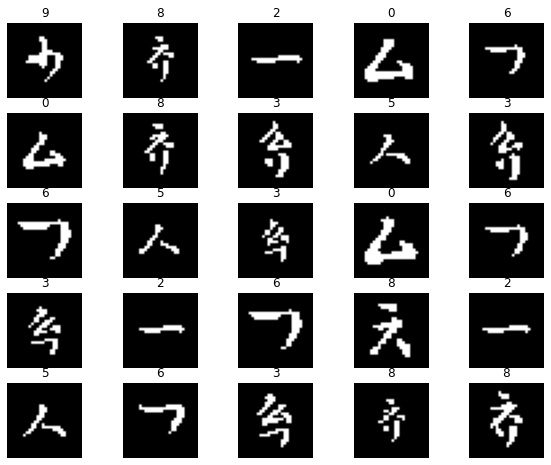

In [47]:
visualize_dataloader(loaders_pitch_siku["test"])

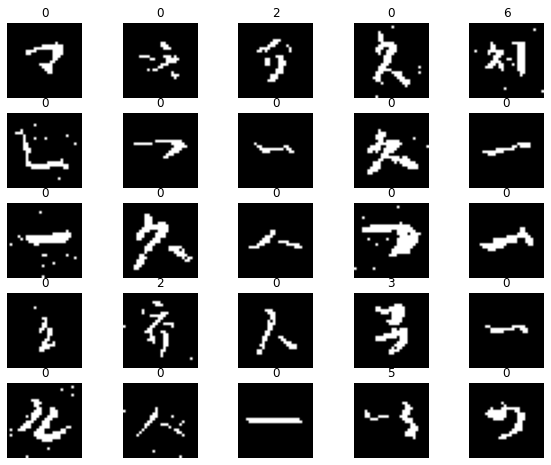

In [48]:
visualize_dataloader(loaders_secondary_lu["train"])

## Defining a Good Loss Function

In [49]:
from torch import optim

def loss_function(x, y):
        return nn.NLLLoss()(x, y)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("DEVICE CODE IS EXECUTED ON:", device)

pitch_to_names = ["He", "Si", "Yi", "Shang", "Gou", "Che", "Gong", "Fan", "Liu", "Wu", "Gao Wu"]
secondary_to_names = ["SIMPLE", "Dadun", "Xiaozhu", "Dingzhu", "Dazhu", "Zhe", "Ye"]

DEVICE CODE IS EXECUTED ON: cpu


In [50]:
from torch.autograd import Variable
num_epochs = 5

def train(num_epochs, model, loaders, LABEL_TYPE, do_validate=False):
    best_model = None
    max_validate = 0
    
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    model.to(device)
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
    
    print(f"Training with")
    print(LABEL_TYPE)
        
    for epoch in range(num_epochs):
        for i, (images, labels, is_simple) in enumerate(loaders['train']):
            images, is_simple = images.to(device), is_simple.to(device)
            
            if "full" in LABEL_TYPE:
                labels = labels[0].to(device), labels[1].to(device)
            else:
                labels = labels.to(device)
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            
            if "full" in LABEL_TYPE:
                b_y = Variable(labels[0]), Variable(labels[1])
            else:
                b_y = Variable(labels)
            
            output = model(b_x)
            
            loss = loss_function(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()
            #backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()      

            if "secondary" in LABEL_TYPE:
                pred_y = torch.argmax(output, dim=1)              
                total_accuracy = (pred_y == labels).sum() / float(len(pred_y))
                pred_y_composite = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
                labels_composite = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
                composite_accuracy = (pred_y_composite == labels_composite).sum() / len(pred_y_composite) 
                
            elif "pitch" in LABEL_TYPE:                
                pred_y = torch.argmax(output, dim=1)
                total_accuracy = (pred_y == labels).sum() / float(len(pred_y))
            
                pred_y_simple = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if is_simple[idx]])
                labels_simple = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if is_simple[idx]])
                simple_accuracy = (pred_y_simple == labels_simple).sum() / len(pred_y_simple)
            else:
                raise Exception("Not implemented")
                        
            if (i+1) % 100 == 0:
                if "full" in LABEL_TYPE:
                    print ('    Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                    print ('    Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc.(Total): {:.2f}%, Acc.(Simple): {:.2f}%, Acc.(Composite): {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), total_accuracy*100, simple_accuracy*100, composite_accuracy*100))
                elif "secondary" in LABEL_TYPE:
                     print ('    Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc.(Total): {:.2f}%, Acc.(Composite): {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), total_accuracy*100, composite_accuracy*100))
                else:
                    print ('    Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc.(Total): {:.2f}%, Acc.(Simple): {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), total_accuracy*100, simple_accuracy*100))
        
        if do_validate:
            current_validate = validate(model, loaders, LABEL_TYPE)
            if current_validate > max_validate:
                print("***BEST MODEL***")
                best_model = copy.deepcopy(model)
                max_validate = current_validate
        else:
            best_model = model
                
    return best_model

In [51]:
def validate(model, loaders, LABEL_TYPE):  
    model.to(device)
    model.eval()
        
    # Train the model
    total_step = len(loaders['test'])
    
    print(f"Validating with")
    print(LABEL_TYPE)
    
    pred_y = []
    full_labels = []
    is_simple_full = []
        
    for i, (images, labels, is_simple) in enumerate(loaders['test']):
        images, is_simple = images.to(device), is_simple.to(device)

        if "full" in LABEL_TYPE:
            labels = labels[0].to(device), labels[1].to(device)
        else:
            labels = labels.to(device)

        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x

        if "full" in LABEL_TYPE:
            b_y = Variable(labels[0]), Variable(labels[1])
        else:
            b_y = Variable(labels)

        output = model(b_x)

        loss = loss_function(output, b_y)
        pred_y += torch.argmax(output, dim=1)
        is_simple_full += is_simple
        full_labels += labels
    
    labels = torch.Tensor(full_labels)
    pred_y = torch.Tensor(pred_y)
    is_simple = torch.Tensor(is_simple_full)
    
    total_accuracy = (pred_y == labels).sum() / float(len(pred_y))
    pred_y_simple = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if is_simple[idx]])
    labels_simple = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if is_simple[idx]])
    simple_accuracy = (pred_y_simple == labels_simple).sum() / len(pred_y_simple)   

    pred_y_composite = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
    labels_composite = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
    composite_accuracy = (pred_y_composite == labels_composite).sum() / len(pred_y_composite) 

    if "full" in LABEL_TYPE:
        print ('    Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        print ('    Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc.(Total): {:.2f}%, Acc.(Simple): {:.2f}%, Acc.(Composite): {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), total_accuracy*100, simple_accuracy*100, composite_accuracy*100))
    elif "secondary" in LABEL_TYPE:
         print ('    Acc.(Total): {:.2f}%, Acc.(Composite): {:.2f}%'.format(total_accuracy*100, composite_accuracy*100))
    else:
        print ('    Acc.(Total): {:.2f}%, Acc.(Simple): {:.2f}%'.format(total_accuracy*100, simple_accuracy*100))
    
    return total_accuracy

# Training with LabelType.PITCH_BALANCED for different editions

In [74]:
#training FashionCNN with PITCH_BALANCED and validation edition NONE     
model_pitch_none = FashionCNN()          
train(num_epochs, model_pitch_none, loaders_pitch_none, LabelType.PITCH_BALANCED)

Training with
pitch_balanced
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])
HAAAPE torch.Size([100, 1, 28, 28])

KeyboardInterrupt: 

In [67]:
validate(model_pitch_none, loaders_pitch_none, LabelType.PITCH_BALANCED)

NameError: name 'model_pitch_none' is not defined

In [58]:
#training FashionCNN with PITCH_BALANCED and validation edition ZHANG     
model_pitch_zhang = FashionCNN()          
train(num_epochs, model_pitch_zhang, loaders_pitch_zhang, LabelType.PITCH_BALANCED)

Training with
pitch_balanced
    Epoch [1/5], Step [100/600], Loss: 0.5304, Acc.(Total): 88.00%, Acc.(Simple): 98.70%
    Epoch [1/5], Step [200/600], Loss: 0.3611, Acc.(Total): 89.00%, Acc.(Simple): 95.18%
    Epoch [1/5], Step [300/600], Loss: 0.4502, Acc.(Total): 86.00%, Acc.(Simple): 94.81%
    Epoch [1/5], Step [400/600], Loss: 0.3730, Acc.(Total): 88.00%, Acc.(Simple): 94.87%
    Epoch [1/5], Step [500/600], Loss: 0.2260, Acc.(Total): 93.00%, Acc.(Simple): 96.15%
    Epoch [1/5], Step [600/600], Loss: 0.3187, Acc.(Total): 91.00%, Acc.(Simple): 91.14%
    Epoch [2/5], Step [100/600], Loss: 0.4714, Acc.(Total): 80.00%, Acc.(Simple): 88.31%
    Epoch [2/5], Step [200/600], Loss: 0.3424, Acc.(Total): 88.00%, Acc.(Simple): 90.79%
    Epoch [2/5], Step [300/600], Loss: 0.2406, Acc.(Total): 89.00%, Acc.(Simple): 94.74%
    Epoch [2/5], Step [400/600], Loss: 0.1803, Acc.(Total): 92.00%, Acc.(Simple): 93.90%
    Epoch [2/5], Step [500/600], Loss: 0.1626, Acc.(Total): 95.00%, Acc.(Simple):

In [59]:
validate(model_pitch_zhang, loaders_pitch_zhang, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 88.86%, Acc.(Simple): 93.51%


In [60]:
#training FashionCNN with PITCH_BALANCED and validation edition ZHU    
model_pitch_zhu = FashionCNN()          
train(num_epochs, model_pitch_zhu, loaders_pitch_zhu, LabelType.PITCH_BALANCED)

Training with
pitch_balanced
    Epoch [1/5], Step [100/600], Loss: 0.5634, Acc.(Total): 80.00%, Acc.(Simple): 87.18%
    Epoch [1/5], Step [200/600], Loss: 0.5325, Acc.(Total): 82.00%, Acc.(Simple): 90.41%
    Epoch [1/5], Step [300/600], Loss: 0.4445, Acc.(Total): 85.00%, Acc.(Simple): 95.31%
    Epoch [1/5], Step [400/600], Loss: 0.2976, Acc.(Total): 88.00%, Acc.(Simple): 93.51%
    Epoch [1/5], Step [500/600], Loss: 0.2546, Acc.(Total): 92.00%, Acc.(Simple): 97.18%
    Epoch [1/5], Step [600/600], Loss: 0.3162, Acc.(Total): 87.00%, Acc.(Simple): 96.10%
    Epoch [2/5], Step [100/600], Loss: 0.5424, Acc.(Total): 86.00%, Acc.(Simple): 94.52%
    Epoch [2/5], Step [200/600], Loss: 0.4416, Acc.(Total): 86.00%, Acc.(Simple): 94.20%
    Epoch [2/5], Step [300/600], Loss: 0.3055, Acc.(Total): 87.00%, Acc.(Simple): 95.83%
    Epoch [2/5], Step [400/600], Loss: 0.1659, Acc.(Total): 94.00%, Acc.(Simple): 93.15%
    Epoch [2/5], Step [500/600], Loss: 0.2585, Acc.(Total): 92.00%, Acc.(Simple):

In [61]:
validate(model_pitch_zhu, loaders_pitch_zhu, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 89.91%, Acc.(Simple): 95.80%


In [62]:
#training FashionCNN with PITCH_BALANCED and validation edition SIKU     
model_pitch_siku = FashionCNN()          
train(num_epochs, model_pitch_siku, loaders_pitch_siku, LabelType.PITCH_BALANCED)

Training with
pitch_balanced
    Epoch [1/5], Step [100/600], Loss: 0.5079, Acc.(Total): 84.00%, Acc.(Simple): 92.41%
    Epoch [1/5], Step [200/600], Loss: 0.5511, Acc.(Total): 85.00%, Acc.(Simple): 95.65%
    Epoch [1/5], Step [300/600], Loss: 0.4781, Acc.(Total): 85.00%, Acc.(Simple): 86.75%
    Epoch [1/5], Step [400/600], Loss: 0.3196, Acc.(Total): 92.00%, Acc.(Simple): 95.83%
    Epoch [1/5], Step [500/600], Loss: 0.3829, Acc.(Total): 90.00%, Acc.(Simple): 96.05%
    Epoch [1/5], Step [600/600], Loss: 0.2731, Acc.(Total): 89.00%, Acc.(Simple): 91.57%
    Epoch [2/5], Step [100/600], Loss: 0.2653, Acc.(Total): 93.00%, Acc.(Simple): 97.44%
    Epoch [2/5], Step [200/600], Loss: 0.4047, Acc.(Total): 91.00%, Acc.(Simple): 95.18%
    Epoch [2/5], Step [300/600], Loss: 0.3448, Acc.(Total): 89.00%, Acc.(Simple): 100.00%
    Epoch [2/5], Step [400/600], Loss: 0.3141, Acc.(Total): 84.00%, Acc.(Simple): 90.79%
    Epoch [2/5], Step [500/600], Loss: 0.2000, Acc.(Total): 93.00%, Acc.(Simple)

Validating with
pitch_balanced
    Acc.(Total): 90.08%, Acc.(Simple): 97.13%


tensor(0.9008)

In [43]:
#training FashionCNN with PITCH_BALANCED and validation edition LU     
model_pitch_lu = FashionCNN()          
best_model_pitch = train(10, model_pitch_lu, loaders_pitch_lu, LabelType.PITCH_BALANCED, do_validate=True)

Training with
pitch_balanced
    Epoch [1/10], Step [100/600], Loss: 0.9521, Acc.(Total): 68.00%, Acc.(Simple): 81.82%
    Epoch [1/10], Step [200/600], Loss: 0.4858, Acc.(Total): 85.00%, Acc.(Simple): 95.12%
    Epoch [1/10], Step [300/600], Loss: 0.3582, Acc.(Total): 89.00%, Acc.(Simple): 96.00%
    Epoch [1/10], Step [400/600], Loss: 0.5141, Acc.(Total): 84.00%, Acc.(Simple): 94.67%
    Epoch [1/10], Step [500/600], Loss: 0.4686, Acc.(Total): 80.00%, Acc.(Simple): 84.62%
    Epoch [1/10], Step [600/600], Loss: 0.3533, Acc.(Total): 87.00%, Acc.(Simple): 97.14%
Validating with
pitch_balanced
    Acc.(Total): 91.06%, Acc.(Simple): 96.64%
***BEST MODEL***
    Epoch [2/10], Step [100/600], Loss: 0.2551, Acc.(Total): 93.00%, Acc.(Simple): 96.10%
    Epoch [2/10], Step [200/600], Loss: 0.4775, Acc.(Total): 87.00%, Acc.(Simple): 91.36%
    Epoch [2/10], Step [300/600], Loss: 0.2923, Acc.(Total): 87.00%, Acc.(Simple): 94.37%
    Epoch [2/10], Step [400/600], Loss: 0.3362, Acc.(Total): 89.00%

In [46]:
torch.save(best_model_pitch.state_dict(), "./model_pitch.std")

In [50]:
validate(best_model_pitch, loaders_pitch_lu, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 94.48%, Acc.(Simple): 97.46%


tensor(0.9448)

# Training with LabelType.SECONDARY_BALANCED for different editions

In [77]:
#training FashionCNN with SECONDARY_BALANCED and validation edition NONE     
model_secondary_none = FashionCNN()          
train(num_epochs, model_secondary_none, loaders_secondary_none, LabelType.SECONDARY_BALANCED)

Training with
secondary_balanced
    Epoch [1/5], Step [100/600], Loss: 0.8064, Acc.(Total): 77.00%, Acc.(Composite): 74.70%
    Epoch [1/5], Step [200/600], Loss: 0.5908, Acc.(Total): 82.00%, Acc.(Composite): 80.68%
    Epoch [1/5], Step [300/600], Loss: 0.5058, Acc.(Total): 81.00%, Acc.(Composite): 79.31%
    Epoch [1/5], Step [400/600], Loss: 0.5540, Acc.(Total): 77.00%, Acc.(Composite): 82.50%
    Epoch [1/5], Step [500/600], Loss: 0.4577, Acc.(Total): 83.00%, Acc.(Composite): 85.71%
    Epoch [1/5], Step [600/600], Loss: 0.4701, Acc.(Total): 88.00%, Acc.(Composite): 88.89%
    Epoch [2/5], Step [100/600], Loss: 0.4679, Acc.(Total): 85.00%, Acc.(Composite): 84.44%
    Epoch [2/5], Step [200/600], Loss: 0.3428, Acc.(Total): 88.00%, Acc.(Composite): 89.89%
    Epoch [2/5], Step [300/600], Loss: 0.4092, Acc.(Total): 85.00%, Acc.(Composite): 86.36%
    Epoch [2/5], Step [400/600], Loss: 0.3341, Acc.(Total): 85.00%, Acc.(Composite): 86.75%
    Epoch [2/5], Step [500/600], Loss: 0.4452, 

In [80]:
validate(model_secondary_none, loaders_secondary_none, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 88.38%, Acc.(Composite): 87.29%


In [81]:
#training FashionCNN with SECONDARY_BALANCED and validation edition ZHANG     
model_secondary_zhang = FashionCNN()          
train(num_epochs, model_secondary_zhang, loaders_secondary_zhang, LabelType.SECONDARY_BALANCED)

Training with
secondary_balanced
    Epoch [1/5], Step [100/600], Loss: 0.7898, Acc.(Total): 73.00%, Acc.(Composite): 69.32%
    Epoch [1/5], Step [200/600], Loss: 0.6332, Acc.(Total): 81.00%, Acc.(Composite): 80.90%
    Epoch [1/5], Step [300/600], Loss: 0.3890, Acc.(Total): 83.00%, Acc.(Composite): 83.91%
    Epoch [1/5], Step [400/600], Loss: 0.5293, Acc.(Total): 80.00%, Acc.(Composite): 81.18%
    Epoch [1/5], Step [500/600], Loss: 0.2670, Acc.(Total): 89.00%, Acc.(Composite): 87.50%
    Epoch [1/5], Step [600/600], Loss: 0.5468, Acc.(Total): 87.00%, Acc.(Composite): 87.64%
    Epoch [2/5], Step [100/600], Loss: 0.4317, Acc.(Total): 87.00%, Acc.(Composite): 86.21%
    Epoch [2/5], Step [200/600], Loss: 0.5367, Acc.(Total): 79.00%, Acc.(Composite): 79.55%
    Epoch [2/5], Step [300/600], Loss: 0.2260, Acc.(Total): 94.00%, Acc.(Composite): 94.94%
    Epoch [2/5], Step [400/600], Loss: 0.4675, Acc.(Total): 86.00%, Acc.(Composite): 84.27%
    Epoch [2/5], Step [500/600], Loss: 0.3487, 

In [82]:
validate(model_secondary_zhang, loaders_secondary_zhang, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 83.39%, Acc.(Composite): 80.79%


In [83]:
#training FashionCNN with SECONDARY_BALANCED and validation edition ZHU    
model_secondary_zhu = FashionCNN()          
train(num_epochs, model_secondary_zhu, loaders_secondary_zhu, LabelType.SECONDARY_BALANCED)

Training with
secondary_balanced
    Epoch [1/5], Step [100/600], Loss: 0.6782, Acc.(Total): 78.00%, Acc.(Composite): 82.72%
    Epoch [1/5], Step [200/600], Loss: 0.8546, Acc.(Total): 73.00%, Acc.(Composite): 70.00%
    Epoch [1/5], Step [300/600], Loss: 0.4515, Acc.(Total): 84.00%, Acc.(Composite): 86.90%
    Epoch [1/5], Step [400/600], Loss: 0.3229, Acc.(Total): 89.00%, Acc.(Composite): 88.89%
    Epoch [1/5], Step [500/600], Loss: 0.3253, Acc.(Total): 88.00%, Acc.(Composite): 86.59%
    Epoch [1/5], Step [600/600], Loss: 0.3045, Acc.(Total): 91.00%, Acc.(Composite): 90.70%
    Epoch [2/5], Step [100/600], Loss: 0.3066, Acc.(Total): 90.00%, Acc.(Composite): 90.80%
    Epoch [2/5], Step [200/600], Loss: 0.3827, Acc.(Total): 88.00%, Acc.(Composite): 87.64%
    Epoch [2/5], Step [300/600], Loss: 0.3961, Acc.(Total): 86.00%, Acc.(Composite): 87.21%
    Epoch [2/5], Step [400/600], Loss: 0.2487, Acc.(Total): 90.00%, Acc.(Composite): 89.89%
    Epoch [2/5], Step [500/600], Loss: 0.4236, 

In [84]:
validate(model_secondary_zhu, loaders_secondary_zhu, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 84.58%, Acc.(Composite): 81.85%


In [85]:
# #training FashionCNN with SECONDARY_BALANCED and validation edition SIKU     
model_secondary_siku = FashionCNN()          
train(num_epochs, model_secondary_siku, loaders_secondary_siku, LabelType.SECONDARY_BALANCED)

Training with
secondary_balanced
    Epoch [1/5], Step [100/600], Loss: 0.6249, Acc.(Total): 75.00%, Acc.(Composite): 71.91%
    Epoch [1/5], Step [200/600], Loss: 0.4500, Acc.(Total): 86.00%, Acc.(Composite): 84.44%
    Epoch [1/5], Step [300/600], Loss: 0.4929, Acc.(Total): 81.00%, Acc.(Composite): 80.68%
    Epoch [1/5], Step [400/600], Loss: 0.4952, Acc.(Total): 82.00%, Acc.(Composite): 80.23%
    Epoch [1/5], Step [500/600], Loss: 0.7273, Acc.(Total): 79.00%, Acc.(Composite): 79.55%
    Epoch [1/5], Step [600/600], Loss: 0.3509, Acc.(Total): 89.00%, Acc.(Composite): 89.16%
    Epoch [2/5], Step [100/600], Loss: 0.4648, Acc.(Total): 84.00%, Acc.(Composite): 82.76%
    Epoch [2/5], Step [200/600], Loss: 0.2897, Acc.(Total): 88.00%, Acc.(Composite): 87.21%
    Epoch [2/5], Step [300/600], Loss: 0.2010, Acc.(Total): 93.00%, Acc.(Composite): 93.02%
    Epoch [2/5], Step [400/600], Loss: 0.6225, Acc.(Total): 82.00%, Acc.(Composite): 83.95%
    Epoch [2/5], Step [500/600], Loss: 0.3117, 

In [86]:
validate(model_secondary_siku, loaders_secondary_siku, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 88.46%, Acc.(Composite): 87.18%


In [52]:
#training FashionCNN with SECONDARY_BALANCED and validation edition LU     
model_secondary_lu = FashionCNN(num_output_classes=7)          
best_model_secondary = train(15, model_secondary_lu, loaders_secondary_lu, LabelType.SECONDARY_BALANCED, do_validate=True)

Training with
secondary_balanced


/home/tristan/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


    Epoch [1/15], Step [100/600], Loss: 0.6813, Acc.(Total): 79.00%, Acc.(Composite): 81.58%
    Epoch [1/15], Step [200/600], Loss: 0.7251, Acc.(Total): 75.00%, Acc.(Composite): 73.86%
    Epoch [1/15], Step [300/600], Loss: 0.4137, Acc.(Total): 89.00%, Acc.(Composite): 88.64%
    Epoch [1/15], Step [400/600], Loss: 0.4424, Acc.(Total): 83.00%, Acc.(Composite): 86.36%
    Epoch [1/15], Step [500/600], Loss: 0.5502, Acc.(Total): 85.00%, Acc.(Composite): 84.62%
    Epoch [1/15], Step [600/600], Loss: 0.4146, Acc.(Total): 87.00%, Acc.(Composite): 86.05%
Validating with
secondary_balanced
    Acc.(Total): 88.48%, Acc.(Composite): 88.52%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.3953, Acc.(Total): 89.00%, Acc.(Composite): 88.10%
    Epoch [2/15], Step [200/600], Loss: 0.4403, Acc.(Total): 83.00%, Acc.(Composite): 80.49%
    Epoch [2/15], Step [300/600], Loss: 0.4184, Acc.(Total): 90.00%, Acc.(Composite): 87.80%
    Epoch [2/15], Step [400/600], Loss: 0.2051, Acc.(Total): 9

    Epoch [13/15], Step [600/600], Loss: 0.0777, Acc.(Total): 99.00%, Acc.(Composite): 100.00%
Validating with
secondary_balanced
    Acc.(Total): 88.90%, Acc.(Composite): 87.88%
    Epoch [14/15], Step [100/600], Loss: 0.1068, Acc.(Total): 95.00%, Acc.(Composite): 96.43%
    Epoch [14/15], Step [200/600], Loss: 0.1730, Acc.(Total): 97.00%, Acc.(Composite): 97.73%
    Epoch [14/15], Step [300/600], Loss: 0.2377, Acc.(Total): 93.00%, Acc.(Composite): 92.31%
    Epoch [14/15], Step [400/600], Loss: 0.1671, Acc.(Total): 94.00%, Acc.(Composite): 93.10%
    Epoch [14/15], Step [500/600], Loss: 0.1427, Acc.(Total): 95.00%, Acc.(Composite): 94.05%
    Epoch [14/15], Step [600/600], Loss: 0.1296, Acc.(Total): 97.00%, Acc.(Composite): 97.78%
Validating with
secondary_balanced
    Acc.(Total): 91.20%, Acc.(Composite): 89.92%
    Epoch [15/15], Step [100/600], Loss: 0.1136, Acc.(Total): 97.00%, Acc.(Composite): 97.73%
    Epoch [15/15], Step [200/600], Loss: 0.1374, Acc.(Total): 95.00%, Acc.(Comp

In [53]:
model_secondary_lu = best_model_secondary

In [73]:
torch.save(best_model_secondary.state_dict(), "./partial_model_secondary.std")

In [68]:
validate(model_secondary_lu, loaders_secondary_lu, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 89.80%, Acc.(Composite): 88.58%


tensor(0.8980)

# Temperature scaling

In [56]:
class TemperatureScalingCalibrationModule(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model

        # the single temperature scaling parameter, the initialization value doesn't
        # seem to matter that much based on some ad-hoc experimentation
        self.temperature = nn.Parameter(torch.ones(1))
        
    def forward_unscaled(self, x):
        logits = self.model(x)
        scores = nn.functional.softmax(logits, dim=1)
        return scores
    
    def forward(self, x):
        scaled_logits = self.forward_logit(x)
        scores = nn.functional.softmax(scaled_logits, dim=1)
        return scores

    def forward_logit(self, x):      
        logits = self.model(x)
        return logits / self.temperature

    def fit(self, data_loader, n_epochs: int = 10, batch_size: int = 64, lr: float = 0.01):
        """fits the temperature scaling parameter."""
        assert isinstance(data_loader, DataLoader), "data_loader must be an instance of DataLoader"
    
        print(self.temperature.requires_grad)
        
        self.freeze_base_model()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(self.parameters(), lr=lr)
        
        for epoch in range(n_epochs):
            for batch in data_loader:
                images, labels, _ = batch  
                images, labels = images.to(device), labels.to(device)
        
                self.zero_grad()
                scaled_logits = self.forward_logit(images)  # Use forward to get scaled logits
                loss = criterion(scaled_logits, labels)
                loss.backward()
                optimizer.step()
    
        return self


    def freeze_base_model(self):
        """remember to freeze base model's parameters when training temperature scaler"""
        self.model.eval()
        for parameter in self.model.parameters():
            parameter.requires_grad = False

        return self

In [57]:
def predict_data_loader(model, data_loader, scaled=True):
    model.eval()  
    predictions = []
    labels = []  
    with torch.no_grad():  
        for batch in data_loader:
            images = batch[0].to(device)
            
            if scaled:
                probs = model.forward(images)
            else:
                probs = model.forward_unscaled(images)
                
            predictions.extend(probs.cpu().numpy())
            labels.extend(batch[1].cpu().numpy())  
    return torch.from_numpy(np.array(predictions)), torch.from_numpy(np.array(labels))

In [58]:
def reliability_diagram(output, true_labels, n_bins=10):
    bins = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]

    accuracies = torch.zeros(n_bins)
    confidences = torch.zeros(n_bins)
    bin_counts = torch.zeros(n_bins)
    
    max_output = output.max(dim=1)
    predicted_confidences = max_output.values
    predicted_labels = max_output.indices
    
    print(predicted_confidences)
    print(predicted_labels)
    print(true_labels)
    
    def get_bin(conf):
        for idx, bin_upper in enumerate(bin_uppers):
            if conf < bin_upper:
                return idx
        return n_bins-1
    
    bin_to_idx = {}
    for bin_number in range(n_bins):
        bin_to_idx[bin_number] = []
    
    for idx, pred_conf in enumerate(predicted_confidences):
        bin_to_idx[get_bin(pred_conf)].append(idx)
    
    for bin_number in range(n_bins):
        bin_idxs = bin_to_idx[bin_number]
        bin_counts[bin_number] = len(bin_idxs)
        if len(bin_idxs) > 0:
            correct = (true_labels[bin_idxs] == predicted_labels[bin_idxs]).float()
            accuracies[bin_number] = correct.mean()
            confidences[bin_number] = predicted_confidences[bin_idxs].mean()

    plt.figure(figsize=(12, 5))

    # Reliability diagram
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(confidences, accuracies, marker='o')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')

    # Histogram 
    plt.subplot(1, 2, 2)
    plt.bar(bin_lowers, bin_counts, width=(bin_uppers[1] - bin_lowers[1]), align='edge', edgecolor='k')
    plt.xlabel('Confidence')
    plt.ylabel('Number of Samples')
    plt.title('Confidence Histogram')

    plt.tight_layout()
    plt.show()

## Training temperature scaling with LabelType.PITCH_BALANCED for different editions

### validation edition NONE   

In [123]:
dataset_size_pitch_none = len(loaders_pitch_none['test'].dataset)
print("Size of the test dataset:", dataset_size_pitch_none)

Size of the test dataset: 1145


In [124]:
image_data_loader_pitch_none = loaders_pitch_none['test']

In [125]:
calibration_module_pitch_none = TemperatureScalingCalibrationModule(model_pitch_none).to(device)
calibration_module_pitch_none.fit(loaders_pitch_none['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_pitch_none.parameters() if p.requires_grad))

validate(model_pitch_none, loaders_pitch_none, LabelType.PITCH_BALANCED)

True
# of parameters:  1
Validating with
pitch_balanced
    Acc.(Total): 88.30%, Acc.(Simple): 95.82%


In [127]:
calibration_module_pitch_none.temperature

Parameter containing:
tensor([1.3858], requires_grad=True)

tensor([0.9999, 0.9953, 0.9674,  ..., 0.9159, 1.0000, 1.0000])
tensor([5, 5, 1,  ..., 6, 1, 7])
tensor([5, 5, 1,  ..., 6, 1, 6])


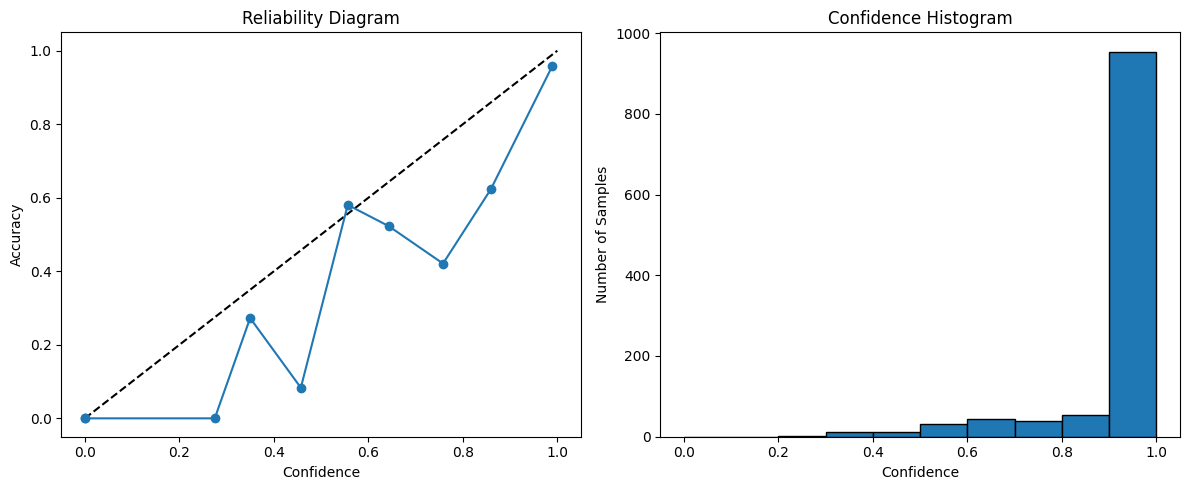

In [128]:
output, labels = predict_data_loader(calibration_module_pitch_none, image_data_loader_pitch_none, scaled=False)
reliability_diagram(output, labels)

tensor([0.9920, 0.9214, 0.9373,  ..., 1.0000, 0.9999, 0.9999])
tensor([5, 6, 9,  ..., 3, 5, 0])
tensor([5, 9, 9,  ..., 3, 5, 0])


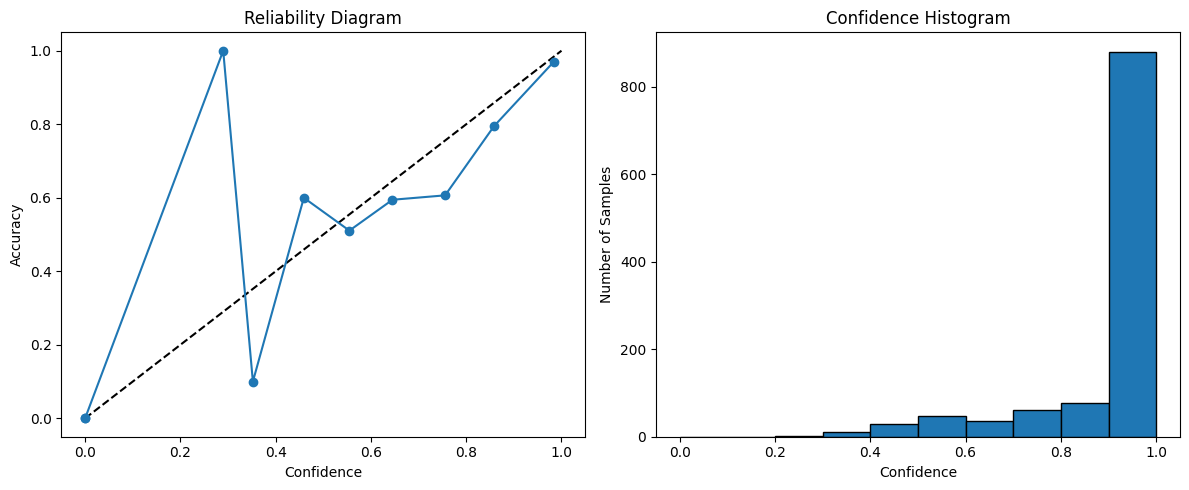

In [129]:
output, labels = predict_data_loader(calibration_module_pitch_none, image_data_loader_pitch_none, scaled=True)
reliability_diagram(output, labels)

### validation edition ZHANG

In [130]:
dataset_size_pitch_zhang = len(loaders_pitch_zhang['test'].dataset)
print("Size of the test dataset:", dataset_size_pitch_zhang)

Size of the test dataset: 1427


In [131]:
image_data_loader_pitch_zhang = loaders_pitch_zhang['test']

In [132]:
calibration_module_pitch_zhang = TemperatureScalingCalibrationModule(model_pitch_zhang).to(device)
calibration_module_pitch_zhang.fit(loaders_pitch_zhang['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_pitch_zhang.parameters() if p.requires_grad))

validate(model_pitch_zhang, loaders_pitch_zhang, LabelType.PITCH_BALANCED)

True
# of parameters:  1
Validating with
pitch_balanced
    Acc.(Total): 89.56%, Acc.(Simple): 93.53%


In [133]:
calibration_module_pitch_zhang.temperature

Parameter containing:
tensor([1.4073], requires_grad=True)

tensor([0.7192, 0.9748, 0.9998,  ..., 0.7207, 0.8676, 1.0000])
tensor([6, 2, 5,  ..., 9, 4, 3])
tensor([10,  2,  5,  ...,  9,  4,  3])


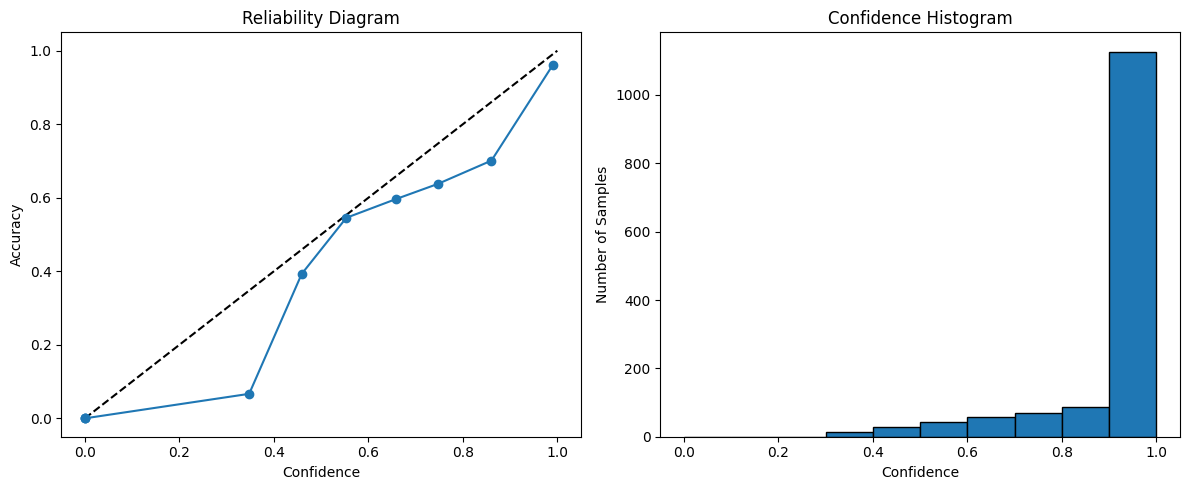

In [134]:
output, labels = predict_data_loader(calibration_module_pitch_zhang, image_data_loader_pitch_zhang, scaled=False)
reliability_diagram(output, labels)

tensor([0.3971, 0.9411, 0.9621,  ..., 0.7655, 0.3516, 0.9434])
tensor([ 7,  8, 10,  ...,  9,  7,  6])
tensor([ 7,  8, 10,  ...,  9,  7,  1])


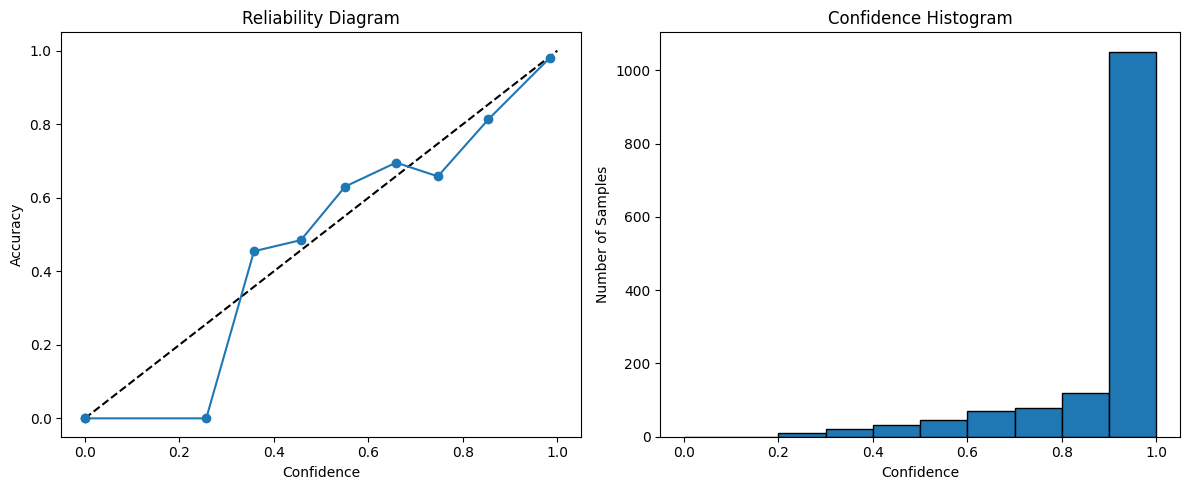

In [135]:
output, labels = predict_data_loader(calibration_module_pitch_zhang, image_data_loader_pitch_zhang, scaled=True)
reliability_diagram(output, labels)

### validation edition ZHU

In [136]:
dataset_size_pitch_zhu = len(loaders_pitch_zhu['test'].dataset)
print("Size of the test dataset:", dataset_size_pitch_zhu)

Size of the test dataset: 1427


In [137]:
image_data_loader_pitch_zhu = loaders_pitch_zhu['test']

In [138]:
calibration_module_pitch_zhu = TemperatureScalingCalibrationModule(model_pitch_zhu).to(device)
calibration_module_pitch_zhu.fit(loaders_pitch_zhu['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_pitch_zhu.parameters() if p.requires_grad))

validate(model_pitch_zhu, loaders_pitch_zhu, LabelType.PITCH_BALANCED)

True
# of parameters:  1
Validating with
pitch_balanced
    Acc.(Total): 88.23%, Acc.(Simple): 94.83%


In [139]:
calibration_module_pitch_zhu.temperature

Parameter containing:
tensor([1.4693], requires_grad=True)

tensor([0.8728, 1.0000, 0.9999,  ..., 1.0000, 0.9899, 0.9991])
tensor([ 9,  0, 10,  ...,  3,  3,  0])
tensor([ 9,  0, 10,  ...,  3,  3,  0])


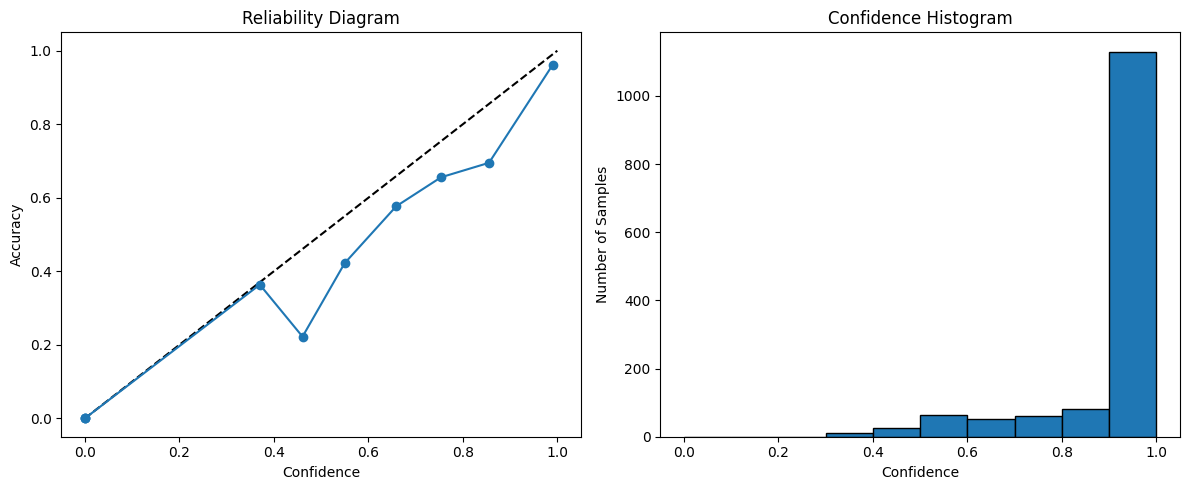

In [140]:
output, labels = predict_data_loader(calibration_module_pitch_zhu, image_data_loader_pitch_zhu, scaled=False)
reliability_diagram(output, labels)

tensor([0.9934, 0.9887, 0.9772,  ..., 0.9997, 0.9877, 1.0000])
tensor([7, 2, 2,  ..., 0, 5, 3])
tensor([7, 2, 2,  ..., 0, 5, 3])


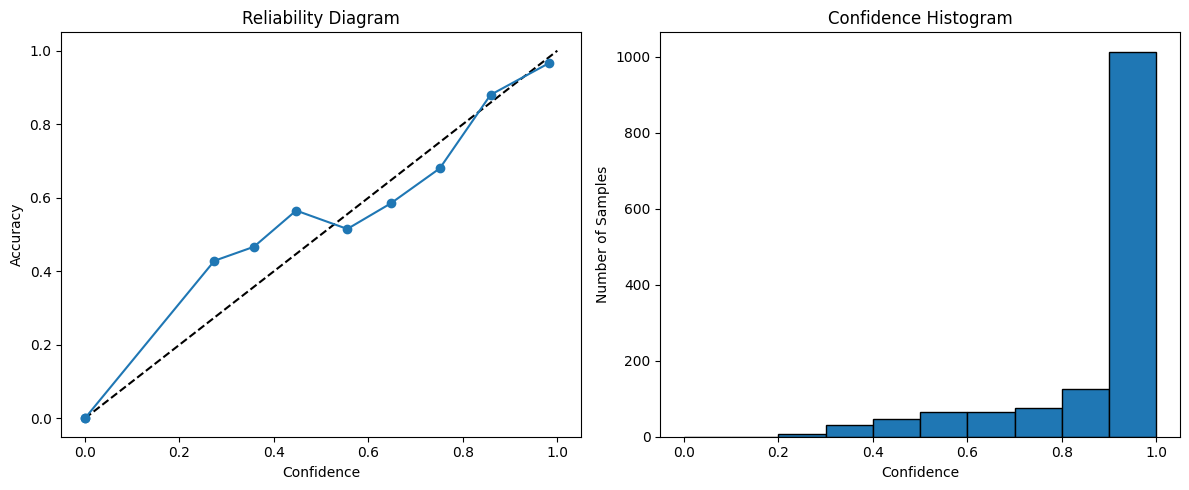

In [141]:
output, labels = predict_data_loader(calibration_module_pitch_zhu, image_data_loader_pitch_zhu, scaled=True)
reliability_diagram(output, labels)

### validation edition SIKU

In [142]:
dataset_size_pitch_siku = len(loaders_pitch_siku['test'].dataset)
print("Size of the test dataset:", dataset_size_pitch_siku)

Size of the test dataset: 1438


In [143]:
image_data_loader_pitch_siku = loaders_pitch_siku['test']

In [144]:
calibration_module_pitch_siku = TemperatureScalingCalibrationModule(model_pitch_siku).to(device)
calibration_module_pitch_siku.fit(loaders_pitch_siku['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_pitch_siku.parameters() if p.requires_grad))

validate(model_pitch_siku, loaders_pitch_siku, LabelType.PITCH_BALANCED)

True
# of parameters:  1
Validating with
pitch_balanced
    Acc.(Total): 90.13%, Acc.(Simple): 95.59%


In [145]:
calibration_module_pitch_siku.temperature

Parameter containing:
tensor([1.3803], requires_grad=True)

tensor([1.0000, 0.9711, 0.9980,  ..., 0.9687, 1.0000, 0.9311])
tensor([ 0, 10,  6,  ..., 10,  3,  6])
tensor([ 0, 10,  6,  ..., 10,  3,  6])


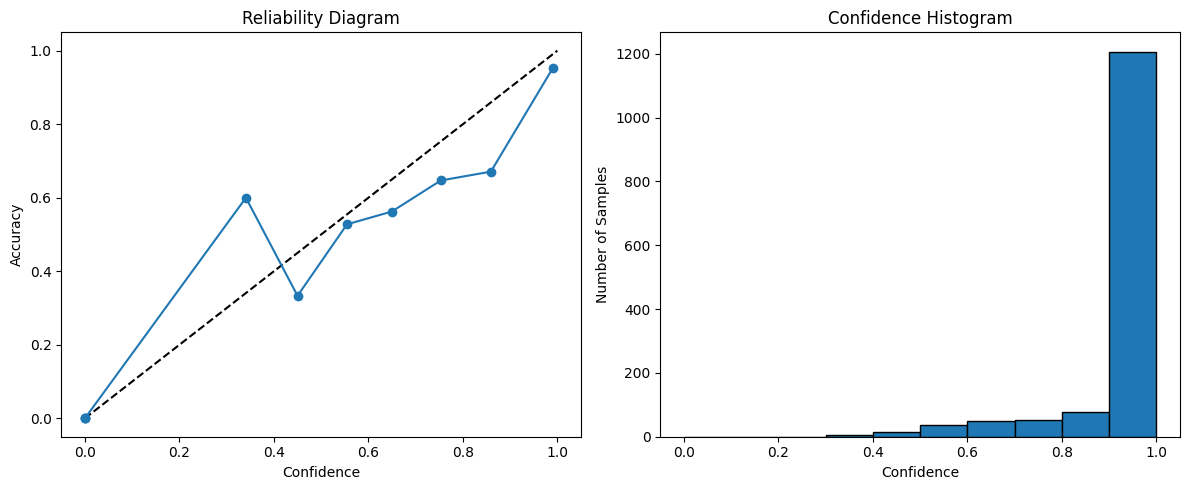

In [146]:
output, labels = predict_data_loader(calibration_module_pitch_siku, image_data_loader_pitch_siku, scaled=False)
reliability_diagram(output, labels)

tensor([0.5688, 0.9955, 1.0000,  ..., 0.9451, 0.9984, 0.7936])
tensor([2, 6, 3,  ..., 9, 0, 1])
tensor([9, 6, 3,  ..., 9, 0, 1])


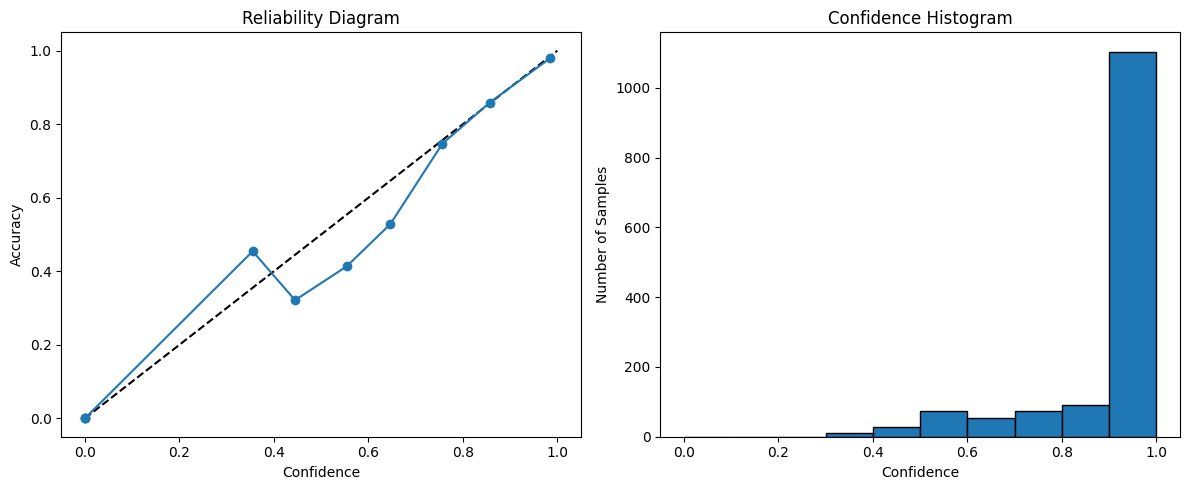

In [147]:
output, labels = predict_data_loader(calibration_module_pitch_siku, image_data_loader_pitch_siku, scaled=True)
reliability_diagram(output, labels)

### validation edition LU

In [56]:
dataset_size_pitch_lu = len(loaders_pitch_lu['test'].dataset)
print("Size of the test dataset:", dataset_size_pitch_lu)

Size of the test dataset: 1432


In [57]:
image_data_loader_pitch_lu = loaders_pitch_lu['test']

In [58]:
calibration_module_pitch_lu = TemperatureScalingCalibrationModule(best_model_pitch).to(device)
calibration_module_pitch_lu.fit(loaders_pitch_lu['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_pitch_lu.parameters() if p.requires_grad))

validate(best_model_pitch, loaders_pitch_lu, LabelType.PITCH_BALANCED)

True
# of parameters:  1
Validating with
pitch_balanced
    Acc.(Total): 94.13%, Acc.(Simple): 97.19%


tensor(0.9413)

In [59]:
calibration_module_pitch_lu.temperature

Parameter containing:
tensor([1.2153], requires_grad=True)

tensor([0.7484, 0.9788, 0.9990,  ..., 0.4464, 1.0000, 0.9709])
tensor([ 9,  2, 10,  ...,  2,  4,  9])
tensor([10,  2, 10,  ..., 10,  4,  9])


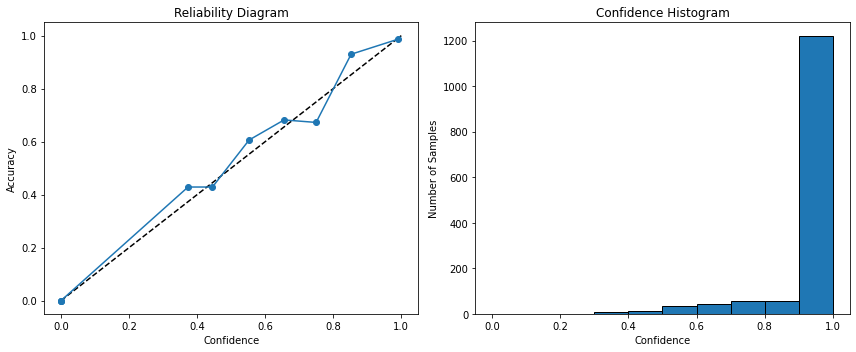

In [64]:
output, labels = predict_data_loader(calibration_module_pitch_lu, image_data_loader_pitch_lu, scaled=False)
reliability_diagram(output, labels)

tensor([1.0000, 0.6056, 1.0000,  ..., 0.9997, 1.0000, 0.8981])
tensor([ 4, 10,  8,  ...,  6,  3, 10])
tensor([ 4, 10,  8,  ...,  6,  3, 10])


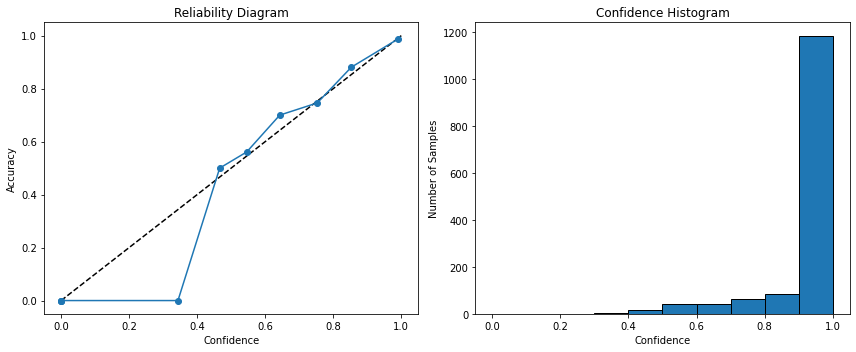

In [63]:
output, labels = predict_data_loader(calibration_module_pitch_lu, image_data_loader_pitch_lu, scaled=True)
reliability_diagram(output, labels)

### Testing which scaled model gives best results 

In [189]:
validate(calibration_module_pitch_none, loaders_pitch_none, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 88.82%, Acc.(Simple): 95.78%


In [191]:
validate(calibration_module_pitch_zhang, loaders_pitch_zhang, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 88.02%, Acc.(Simple): 92.33%


In [193]:
validate(calibration_module_pitch_zhu, loaders_pitch_zhu, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 90.12%, Acc.(Simple): 94.99%


In [195]:
validate(calibration_module_pitch_siku, loaders_pitch_siku, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 90.26%, Acc.(Simple): 95.07%


In [197]:
validate(calibration_module_pitch_lu, loaders_pitch_lu, LabelType.PITCH_BALANCED)

Validating with
pitch_balanced
    Acc.(Total): 93.51%, Acc.(Simple): 97.14%


## Training temperature scaling with LabelType.SECONDARY_BALANCED for different editions

### validation edition NONE

In [154]:
dataset_size_secondary_none = len(loaders_secondary_none['test'].dataset)
print("Size of the test dataset:", dataset_size_secondary_none)

Size of the test dataset: 1145


In [155]:
image_data_loader_secondary_none = loaders_secondary_none['test']

In [156]:
calibration_module_secondary_none = TemperatureScalingCalibrationModule(model_secondary_none).to(device)
calibration_module_secondary_none.fit(loaders_secondary_none['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_secondary_none.parameters() if p.requires_grad))

validate(model_secondary_none, loaders_secondary_none, LabelType.SECONDARY_BALANCED)

True
# of parameters:  1
Validating with
secondary_balanced
    Acc.(Total): 87.69%, Acc.(Composite): 86.89%


In [157]:
calibration_module_secondary_none.temperature

Parameter containing:
tensor([1.4248], requires_grad=True)

tensor([0.9961, 0.9999, 0.6308,  ..., 0.7699, 0.9851, 0.9712])
tensor([3, 3, 6,  ..., 2, 1, 5])
tensor([3, 3, 6,  ..., 2, 1, 3])


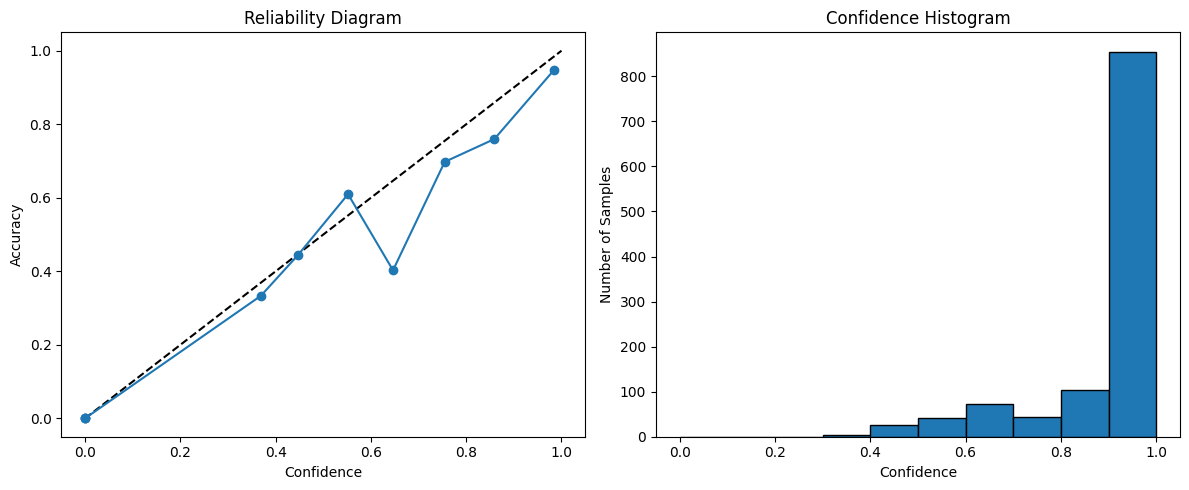

In [158]:
output, labels = predict_data_loader(calibration_module_secondary_none, image_data_loader_secondary_none, scaled=False)
reliability_diagram(output, labels)

tensor([0.4574, 0.9810, 0.9744,  ..., 0.9916, 0.9980, 0.9881])
tensor([2, 5, 3,  ..., 5, 4, 3])
tensor([2, 5, 3,  ..., 5, 4, 3])


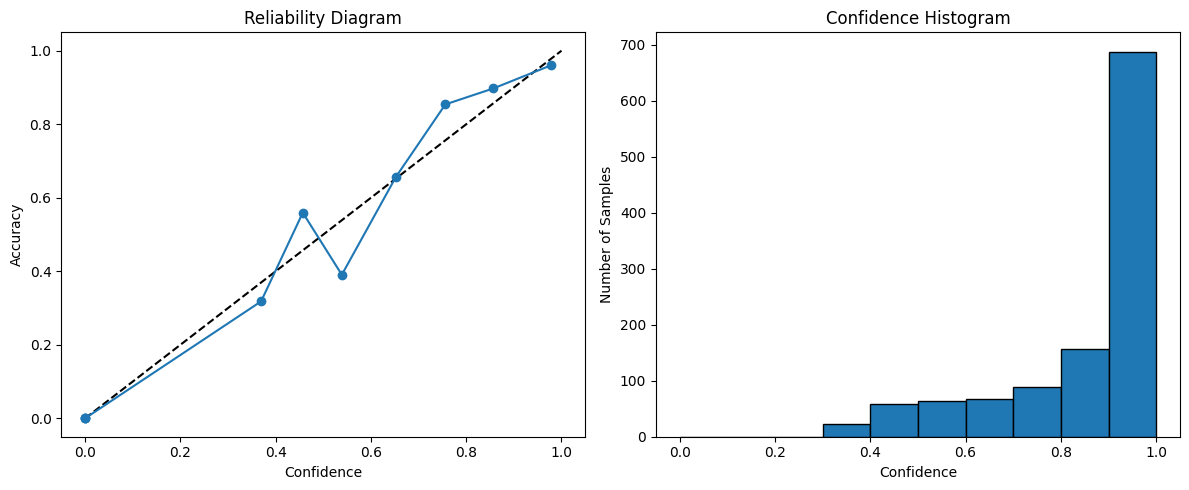

In [159]:
output, labels = predict_data_loader(calibration_module_secondary_none, image_data_loader_secondary_none, scaled=True)
reliability_diagram(output, labels)

### validation edition ZHANG

In [160]:
dataset_size_secondary_zhang = len(loaders_secondary_zhang['test'].dataset)
print("Size of the test dataset:", dataset_size_secondary_zhang)

Size of the test dataset: 1427


In [161]:
image_data_loader_secondary_zhang = loaders_secondary_zhang['test']

In [162]:
calibration_module_secondary_zhang = TemperatureScalingCalibrationModule(model_secondary_zhang).to(device)
calibration_module_secondary_zhang.fit(loaders_secondary_zhang['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_secondary_zhang.parameters() if p.requires_grad))

validate(model_secondary_zhang, loaders_secondary_zhang, LabelType.SECONDARY_BALANCED)

True
# of parameters:  1
Validating with
secondary_balanced
    Acc.(Total): 82.34%, Acc.(Composite): 79.35%


In [163]:
calibration_module_secondary_zhang.temperature

Parameter containing:
tensor([1.5820], requires_grad=True)

tensor([1.0000, 0.4766, 0.9191,  ..., 0.9883, 0.9500, 0.9996])
tensor([0, 5, 2,  ..., 3, 1, 2])
tensor([0, 5, 2,  ..., 3, 1, 2])


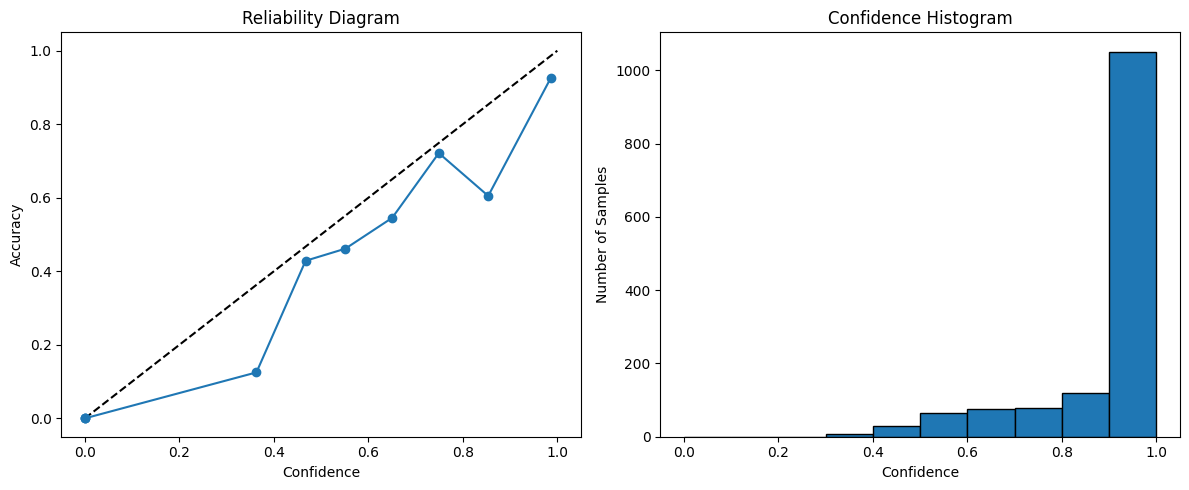

In [164]:
output, labels = predict_data_loader(calibration_module_secondary_zhang, image_data_loader_secondary_zhang, scaled=False)
reliability_diagram(output, labels)

tensor([0.9588, 0.6797, 0.9967,  ..., 0.9984, 0.9699, 0.7866])
tensor([3, 6, 2,  ..., 5, 2, 3])
tensor([3, 6, 2,  ..., 5, 2, 4])


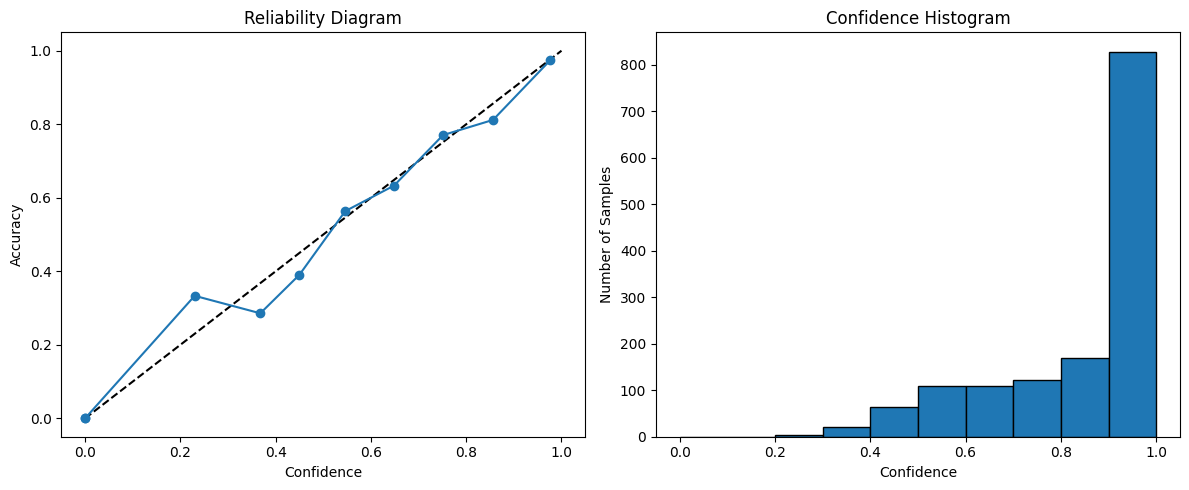

In [165]:
output, labels = predict_data_loader(calibration_module_secondary_zhang, image_data_loader_secondary_zhang, scaled=True)
reliability_diagram(output, labels)

### validation edition ZHU

In [166]:
dataset_size_secondary_zhu = len(loaders_secondary_zhu['test'].dataset)
print("Size of the test dataset:", dataset_size_secondary_zhu)

Size of the test dataset: 1427


In [167]:
image_data_loader_secondary_zhu = loaders_secondary_zhu['test']

In [168]:
calibration_module_secondary_zhu = TemperatureScalingCalibrationModule(model_secondary_zhu).to(device)
calibration_module_secondary_zhu.fit(loaders_secondary_zhu['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_secondary_zhu.parameters() if p.requires_grad))

validate(model_secondary_zhu, loaders_secondary_zhu, LabelType.SECONDARY_BALANCED)

True
# of parameters:  1
Validating with
secondary_balanced
    Acc.(Total): 85.91%, Acc.(Composite): 84.03%


In [169]:
calibration_module_secondary_zhu.temperature

Parameter containing:
tensor([1.5100], requires_grad=True)

tensor([0.9065, 0.6539, 0.4730,  ..., 0.9999, 0.9980, 0.7792])
tensor([1, 5, 3,  ..., 0, 0, 1])
tensor([1, 3, 3,  ..., 0, 0, 1])


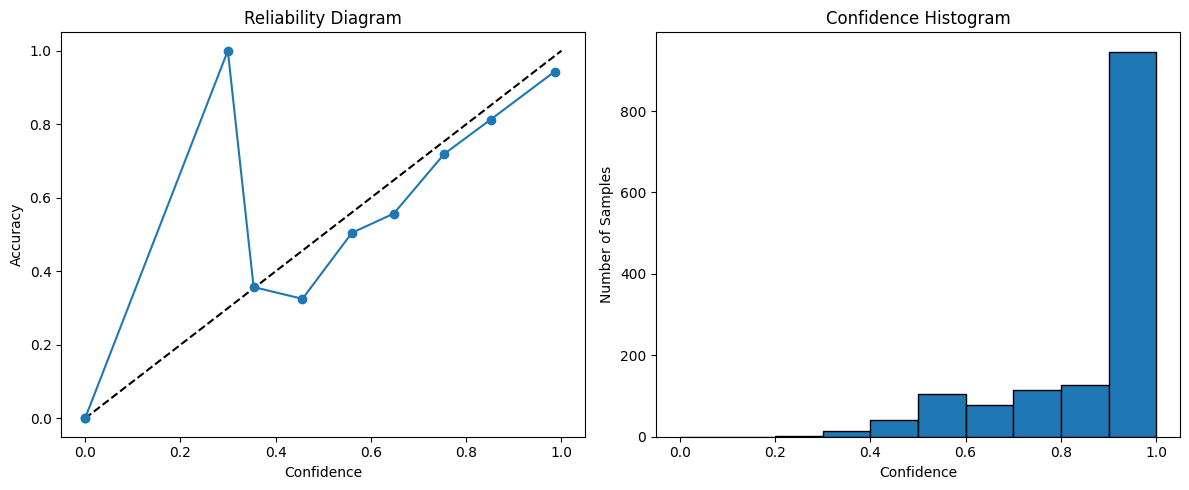

In [170]:
output, labels = predict_data_loader(calibration_module_secondary_zhu, image_data_loader_secondary_zhu, scaled=False)
reliability_diagram(output, labels)

tensor([0.6411, 0.9966, 0.5716,  ..., 0.6493, 0.6511, 0.9927])
tensor([6, 0, 6,  ..., 0, 6, 4])
tensor([2, 0, 2,  ..., 2, 6, 4])


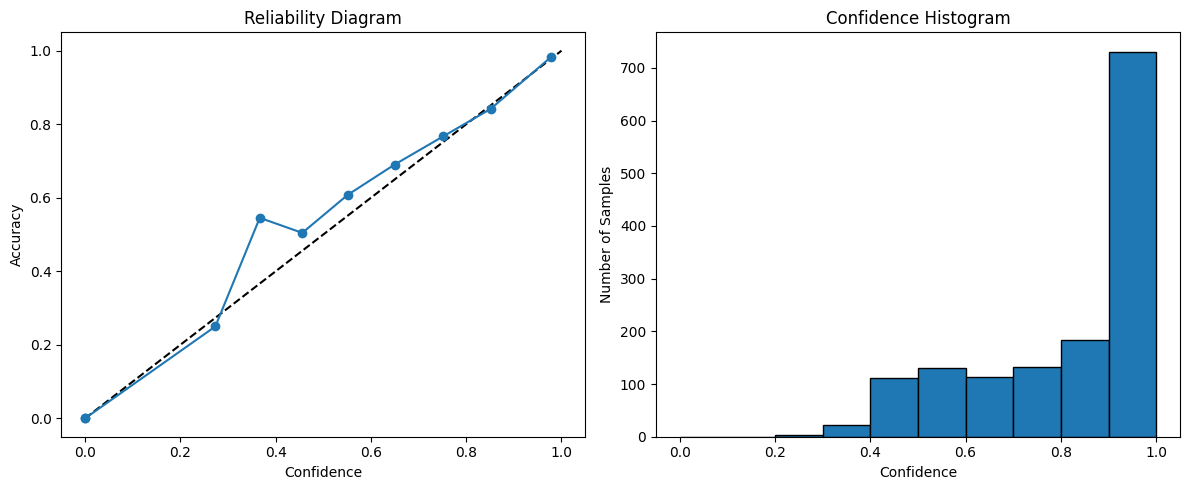

In [171]:
output, labels = predict_data_loader(calibration_module_secondary_zhu, image_data_loader_secondary_zhu, scaled=True)
reliability_diagram(output, labels)

### validation edition SIKU

In [172]:
dataset_size_secondary_siku = len(loaders_secondary_siku['test'].dataset)
print("Size of the test dataset:", dataset_size_secondary_siku)

Size of the test dataset: 1438


In [173]:
image_data_loader_secondary_siku = loaders_secondary_siku['test']

In [174]:
calibration_module_secondary_siku = TemperatureScalingCalibrationModule(model_secondary_siku).to(device)
calibration_module_secondary_siku.fit(loaders_secondary_siku['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_secondary_siku.parameters() if p.requires_grad))

validate(model_secondary_siku, loaders_secondary_siku, LabelType.SECONDARY_BALANCED)

True
# of parameters:  1
Validating with
secondary_balanced
    Acc.(Total): 87.20%, Acc.(Composite): 85.61%


In [175]:
calibration_module_secondary_siku.temperature

Parameter containing:
tensor([1.4500], requires_grad=True)

tensor([1.0000, 0.9147, 0.9985,  ..., 0.9986, 1.0000, 0.9683])
tensor([1, 2, 6,  ..., 4, 0, 2])
tensor([1, 4, 6,  ..., 4, 0, 2])


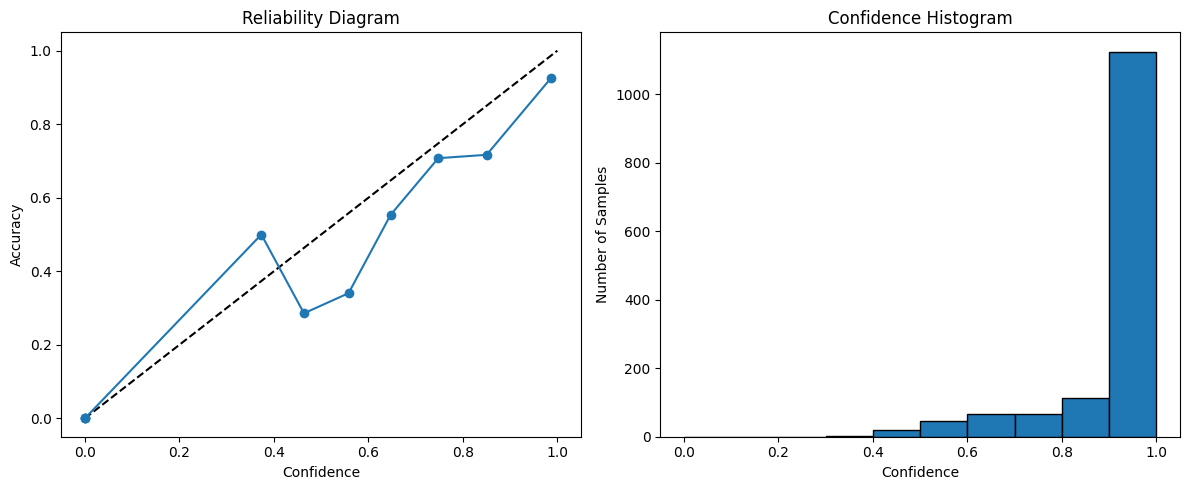

In [176]:
output, labels = predict_data_loader(calibration_module_secondary_siku, image_data_loader_secondary_siku, scaled=False)
reliability_diagram(output, labels)

tensor([0.5212, 0.9998, 0.9381,  ..., 0.9921, 0.8322, 1.0000])
tensor([1, 0, 3,  ..., 0, 2, 0])
tensor([4, 0, 3,  ..., 0, 4, 0])


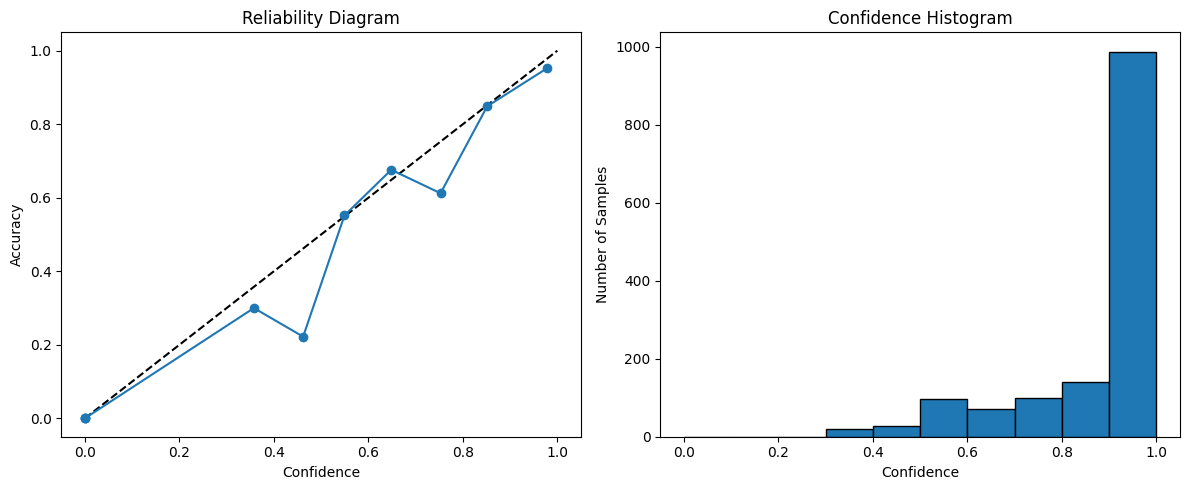

In [177]:
output, labels = predict_data_loader(calibration_module_secondary_siku, image_data_loader_secondary_siku, scaled=True)
reliability_diagram(output, labels)

### validation edition LU

In [65]:
dataset_size_secondary_lu = len(loaders_secondary_lu['test'].dataset)
print("Size of the test dataset:", dataset_size_secondary_lu)

Size of the test dataset: 1432


In [59]:
image_data_loader_secondary_lu = loaders_secondary_lu['test']

In [60]:
calibration_module_secondary_lu = TemperatureScalingCalibrationModule(best_model_secondary).to(device)
calibration_module_secondary_lu.fit(loaders_secondary_lu['test'])
print('# of parameters: ', sum(p.numel() for p in calibration_module_secondary_lu.parameters() if p.requires_grad))

validate(best_model_secondary, loaders_secondary_lu, LabelType.SECONDARY_BALANCED)

True
# of parameters:  1
Validating with
secondary_balanced
    Acc.(Total): 91.83%, Acc.(Composite): 90.63%


tensor(0.9183)

In [64]:
torch.save(calibration_module_secondary_lu.state_dict(), "./model_secondary.std")

In [61]:
calibration_module_secondary_lu.temperature

Parameter containing:
tensor([1.4211], requires_grad=True)

tensor([1.0000, 0.5148, 0.9997,  ..., 0.5940, 1.0000, 1.0000])
tensor([4, 3, 2,  ..., 1, 3, 0])
tensor([4, 2, 2,  ..., 1, 3, 0])


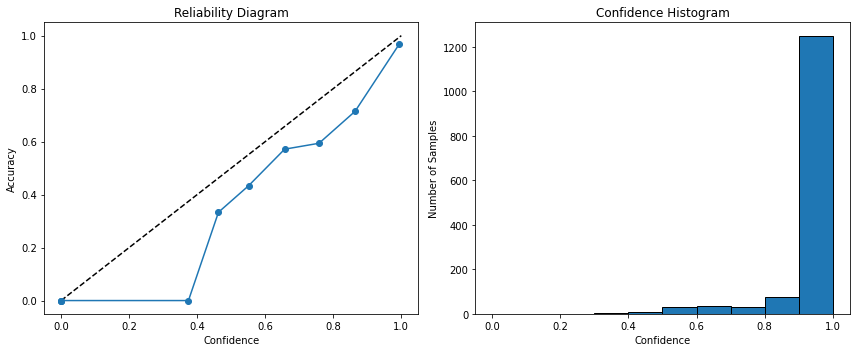

In [70]:
output, labels = predict_data_loader(calibration_module_secondary_lu, image_data_loader_secondary_lu, scaled=False)
reliability_diagram(output, labels)

tensor([1.0000, 0.9978, 0.9998,  ..., 0.9998, 0.9892, 1.0000])
tensor([2, 4, 0,  ..., 1, 6, 1])
tensor([2, 4, 0,  ..., 1, 6, 1])


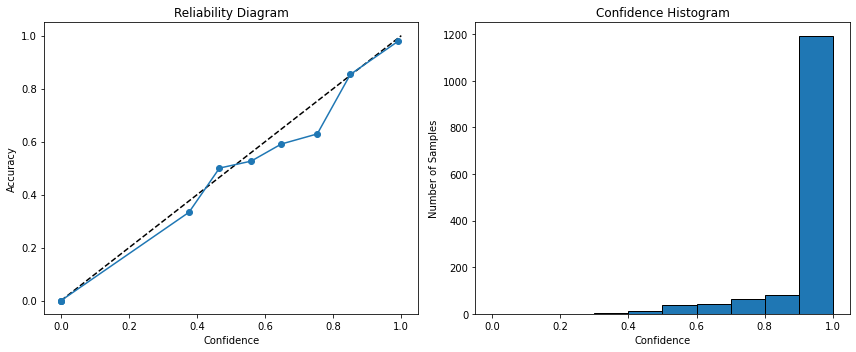

In [71]:
output, labels = predict_data_loader(calibration_module_secondary_lu, image_data_loader_secondary_lu, scaled=True)
reliability_diagram(output, labels)

### Testing which scaled model gives best results

In [198]:
validate(calibration_module_secondary_none, loaders_secondary_none, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 86.81%, Acc.(Composite): 85.60%


In [199]:
validate(calibration_module_secondary_zhang, loaders_secondary_zhang, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 81.08%, Acc.(Composite): 78.16%


In [200]:
validate(calibration_module_secondary_zhu, loaders_secondary_zhu, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 84.86%, Acc.(Composite): 82.36%


In [201]:
validate(calibration_module_secondary_siku, loaders_secondary_siku, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 86.79%, Acc.(Composite): 85.51%


In [202]:
validate(calibration_module_secondary_lu, loaders_secondary_lu, LabelType.SECONDARY_BALANCED)

Validating with
secondary_balanced
    Acc.(Total): 91.20%, Acc.(Composite): 90.25%


# Misprediction visualization

In [54]:
import dataclasses

def get_label_to_names_function(label_type):
    if "pitch" == label_type.split("_")[0]:
        label_to_names = lambda label: pitch_to_names[label]
    elif "secondary" == label_type.split("_")[0]:
        label_to_names = lambda label: secondary_to_names[label]
    elif "full" == label_type.split("_")[0]:
        label_to_names = lambda label: f"{pitch_to_names[label]}/{secondary_to_names[label]}"
    else:
        raise NotImplemented
    
    return label_to_names

def test(model, LABEL_TYPE, VALIDATION_EDITION, test_both_balanced_and_imbalanced=False):
    # Test the model
    model.eval()
    
    total_number = 0
    total_correct = 0
    
    simple_number = 0
    simple_correct = 0
    
    composite_number = 0
    composite_correct = 0
    
    label_to_names = get_label_to_names_function(LABEL_TYPE)
    if "pitch" == LABEL_TYPE.split("_")[0]:
        mispredictions = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}
        per_class = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}
    elif "secondary" == LABEL_TYPE.split("_")[0]:
        mispredictions = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
        per_class = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
    elif "full" == LABEL_TYPE.split("_")[0]:
        mispredictions = None
        per_class = None
    
    print(f"Test Accuracies for predicting '{LABEL_TYPE}':")
    
    if test_both_balanced_and_imbalanced:
        validation_types = [validation_type for validation_type in dataclasses.astuple(LabelType()) if validation_type.split("_")[0] == LABEL_TYPE.split("_")[0]]
    else:
        validation_types = [LABEL_TYPE]
        
        
    for validation_type in validation_types:  # make validation tests for both unbalanced and balanced sets!        
        loaders = get_dataloaders(validation_edition=VALIDATION_EDITION, label_type=validation_type)
        with torch.no_grad():            
            for images, labels, is_simple in loaders['test']:
                images, labels, is_simple = images.to(device), labels.to(device), is_simple.to(device)

                test_output = model(images)

                pred_y = torch.max(test_output, 1)[1].data.squeeze()

                for idx, true_class in enumerate(labels):
                    per_class[true_class.item()].append({"prediction": pred_y[idx].item(), "is_simple": is_simple[idx].item()})
                    if true_class.item() != pred_y[idx].item():
                        mispredictions[true_class.item()].append({"image": images[idx].to('cpu'), "false_label": pred_y[idx].item(), "is_simple": is_simple[idx].item()})
               
                total_number += len(pred_y)
                total_correct += (pred_y == labels).sum()

                pred_y_simple = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if is_simple[idx]])
                labels_simple = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if is_simple[idx]])
                simple_number += len(pred_y_simple)
                simple_correct += (pred_y_simple == labels_simple).sum()

                pred_y_composite = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
                labels_composite = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
                composite_number += len(pred_y_composite)
                composite_correct += (pred_y_composite == labels_composite).sum()

            total_accuracy = total_correct/total_number
            simple_accuracy = simple_correct/simple_number
            composite_accuracy = composite_correct/composite_number
        
            validation_string = f"    Validation type: '{validation_type}', Validation dataset: "
            validation_string += f"Whole edition '{VALIDATION_EDITION}'" if VALIDATION_EDITION else "20% of total data"
            print(validation_string)
            print( "        Validation Set Composition:")
            print(f"            : Total     100.00% ({total_number} samples)")
            print(f"            : Simple     {simple_number/total_number*100:3.2f}% ({simple_number} samples)")
            print(f"            : Composite  {composite_number/total_number*100:3.2f}% ({composite_number} samples)")
            print(f"        Overall Prediction Accuracies:")
            print(f"            : Total      {total_accuracy*100:.2f}%")
            print(f"            : Simple     {simple_accuracy*100:.2f}%")
            print(f"            : Composite: {composite_accuracy*100:.2f}%")
            print(f"        Individual Class Prediction Accuracies:")
            for true_label in per_class.keys():
                total_labels = torch.Tensor([element["prediction"] for element in per_class[true_label]])
                class_total = (total_labels == true_label).sum() / len(total_labels)
                simple_labels = torch.Tensor([element["prediction"] for element in per_class[true_label] if element["is_simple"]])
                class_simple = (simple_labels == true_label).sum() / len(simple_labels)
                composite_labels = torch.Tensor([element["prediction"] for element in per_class[true_label] if not element["is_simple"]])
                class_composite = (composite_labels == true_label).sum() / len(composite_labels)
                print(f"            Class '{label_to_names(true_label)}' ({len(per_class[true_label])} samples):")
                print(f"                Total:     {class_total*100:.2f}%")
                print(f"                Simple:    {class_simple*100:.2f}%")
                print(f"                Composite: {class_composite*100:.2f}%")
    
    return mispredictions


In [56]:
#mispredictions = test(model, test_both_balanced_and_imbalanced=True)  # Test for both the original and balanced data
filler_image = torch.ones((28, 28)) * 255

def visualize_mispredictions(mispredictions, label_to_names, samples_per_class=5):
    figure = plt.figure(figsize=(10, 20))
    cols, rows = samples_per_class, 11
    
    for i in range(1, cols * rows + 1):
        col = (i-1) % cols
        row = (i-1) // cols
        
        try:
            img = mispredictions[row][col]["image"]
            img -= img.min()
            img /= img.max()
            false = label_to_names(mispredictions[row][col]["false_label"])
            label = f"{label_to_names(row)} -> {false}"
        except Exception:
            img = filler_image
            label = ""

        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray", vmin=0, vmax=1)
    plt.show()
    

In [205]:
mispredictions_pitch = test(calibration_module_pitch_lu, "pitch", Editions.LU)

Test Accuracies for predicting 'pitch':
    Validation type: 'pitch', Validation dataset: Whole edition 'lu'
        Validation Set Composition:
            : Total     100.00% (1432 samples)
            : Simple     72.84% (1043 samples)
            : Composite  27.16% (389 samples)
        Overall Prediction Accuracies:
            : Total      92.60%
            : Simple     97.22%
            : Composite: 80.21%
        Individual Class Prediction Accuracies:
            Class 'He' (98 samples):
                Total:     95.92%
                Simple:    98.81%
                Composite: 78.57%
            Class 'Si' (88 samples):
                Total:     98.86%
                Simple:    100.00%
                Composite: 95.24%
            Class 'Yi' (192 samples):
                Total:     94.79%
                Simple:    98.26%
                Composite: 89.61%
            Class 'Shang' (177 samples):
                Total:     92.09%
                Simple:    97.67%
    

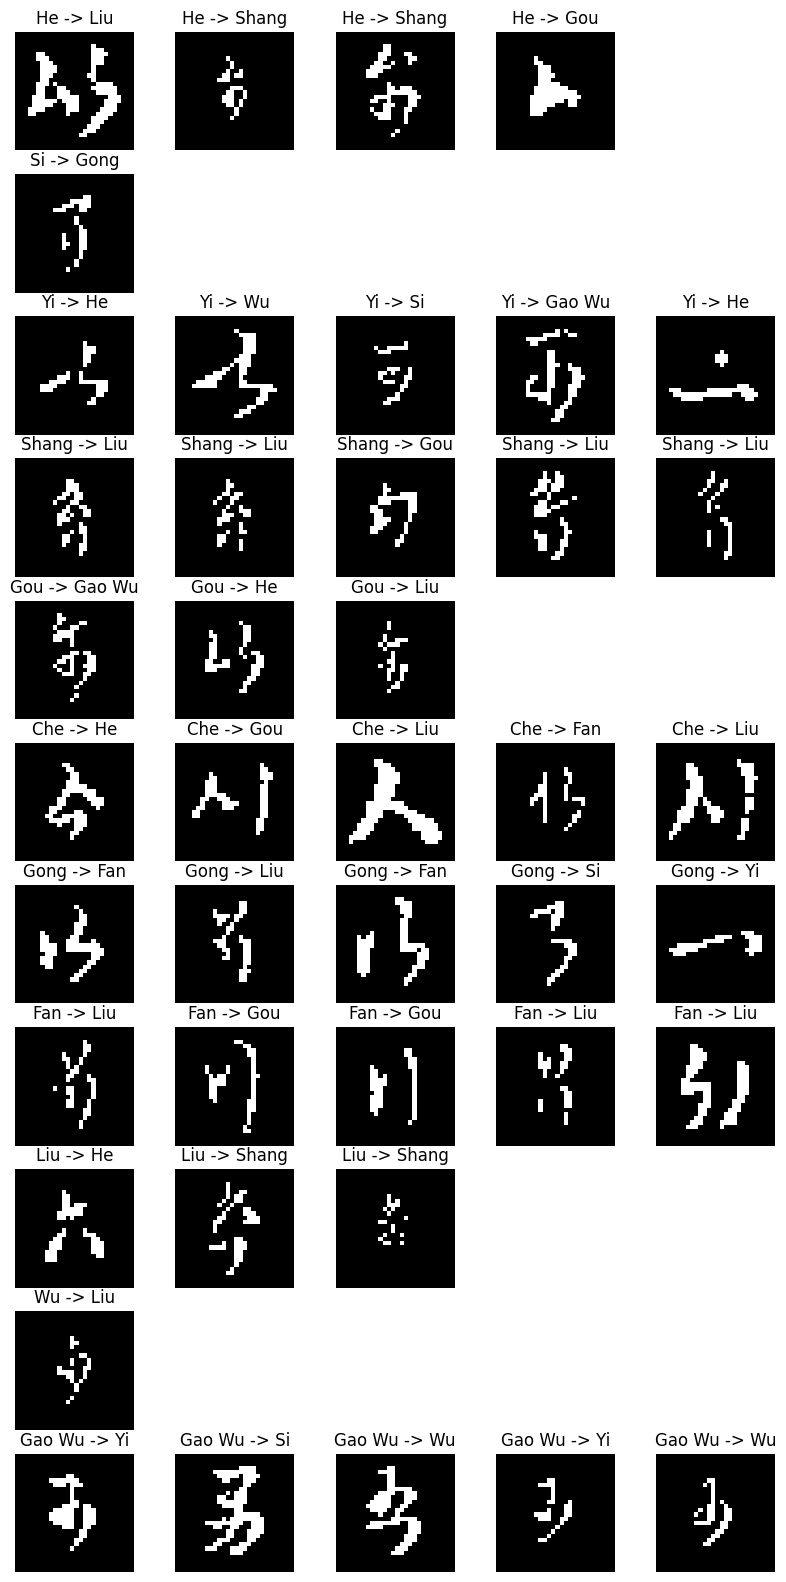

In [206]:
visualize_mispredictions(mispredictions_pitch, get_label_to_names_function("pitch"), samples_per_class=5)

In [207]:
mispredictions_secondary = test(calibration_module_secondary_lu, "secondary", Editions.LU)

Test Accuracies for predicting 'secondary':
    Validation type: 'secondary', Validation dataset: Whole edition 'lu'
        Validation Set Composition:
            : Total     100.00% (1432 samples)
            : Simple     72.84% (1043 samples)
            : Composite  27.16% (389 samples)
        Overall Prediction Accuracies:
            : Total      93.92%
            : Simple     95.21%
            : Composite: 90.49%
        Individual Class Prediction Accuracies:
            Class 'SIMPLE' (1043 samples):
                Total:     95.21%
                Simple:    95.21%
                Composite: nan%
            Class 'Dadun' (80 samples):
                Total:     93.75%
                Simple:    nan%
                Composite: 93.75%
            Class 'Xiaozhu' (46 samples):
                Total:     89.13%
                Simple:    nan%
                Composite: 89.13%
            Class 'Dingzhu' (114 samples):
                Total:     85.09%
                Simple

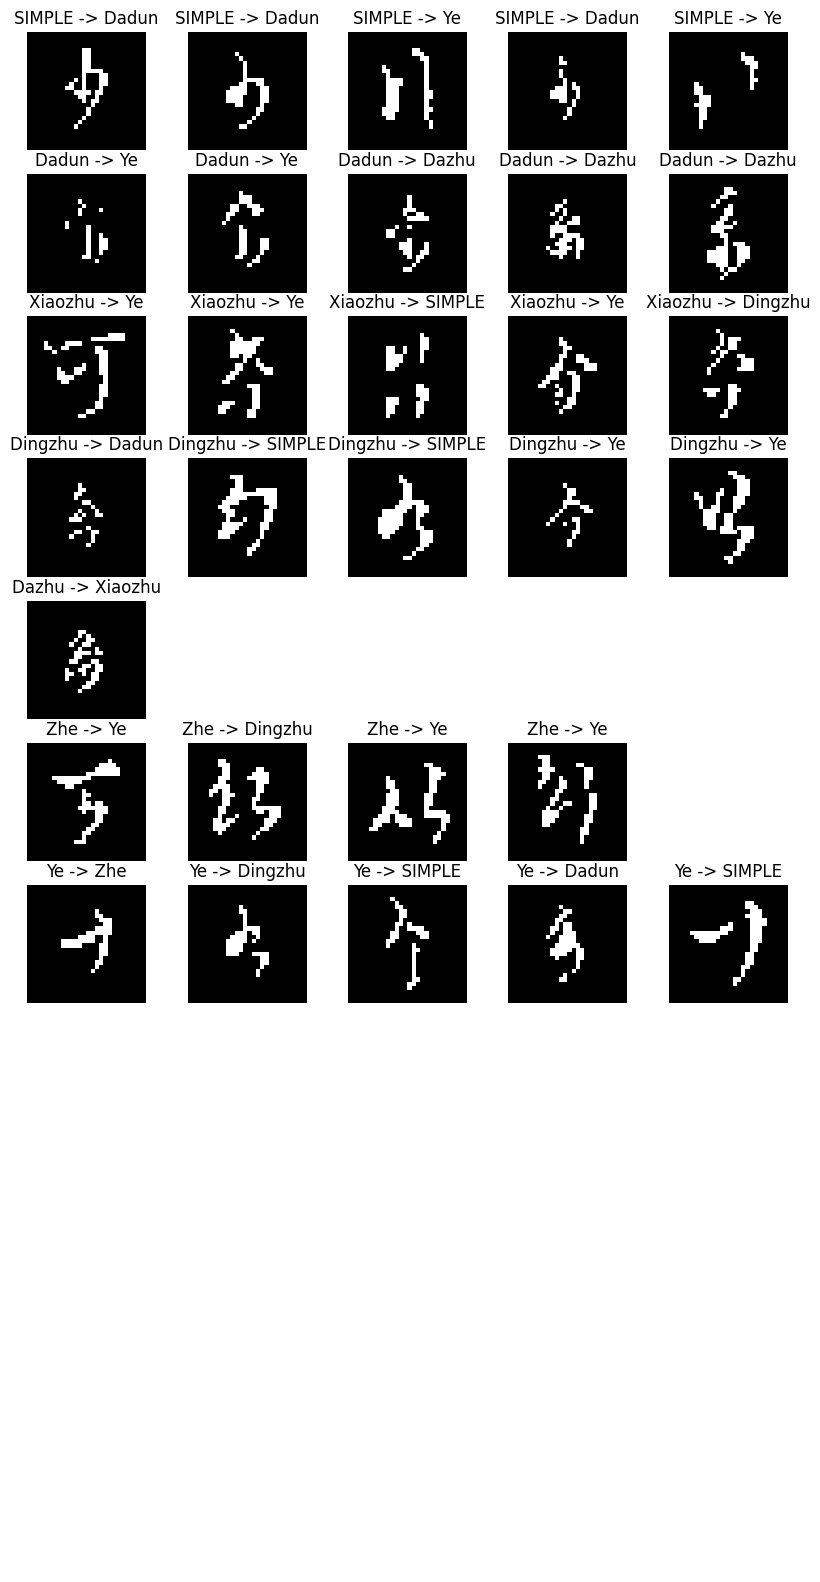

In [208]:
visualize_mispredictions(mispredictions_secondary, get_label_to_names_function("secondary"), samples_per_class=5)